In [24]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

from plotting import plot_utils, summary_plots, load_fits, plot_prf_params, pycortex_plot_utils
plot_utils.set_all_font_sizes(12)
from utils import roi_utils, default_paths, stats_utils
from analyze_fits import analyze_gabor_params

import copy
import cmocean


from utils import prf_utils,numpy_utils, nsd_utils
import scipy.stats


import numpy as np
from utils import circ_utils
from feature_extraction import gabor_feature_extractor

import pandas as pd


In [25]:
n_sf=8; n_ori=12;
_gabor_ext_complex = gabor_feature_extractor.gabor_extractor_multi_scale(n_ori=n_ori, n_sf=n_sf)

screen_eccen_deg=8.4
sf_cyc_per_stim = _gabor_ext_complex.feature_table['SF: cycles per stim']
sf_cyc_per_deg = sf_cyc_per_stim/screen_eccen_deg
sf_unique, sf_inds = np.unique(sf_cyc_per_deg, return_inverse=True)

ori_deg = _gabor_ext_complex.feature_table['Orientation: degrees']
ori_unique, orient_inds = np.unique(ori_deg, return_inverse=True)


In [26]:
# Load results of the fitting procedure
subjects = np.arange(1,9)

n_subjects = len(subjects)

fitting_type = 'gabor_solo_ridge_12ori_8sf'

trial_subsets = ['balance_indoor_outdoor','outdoor_only','indoor_only',\
                 'balance_animacy', 'animate_only', 'inanimate_only',\
                 'balance_real_world_size_binary','large_only', 'small_only']

n_trial_subsets = len(trial_subsets)

out_all = []
for ti, ts in enumerate(trial_subsets):
    
    if ts=='all_trials':
        ft = fitting_type
    else:
        ft ='%s_%s'%(fitting_type, ts)

    out = [load_fits.load_fit_results(subject=ss, fitting_type=ft, \
                                      n_from_end=0, \
                                  verbose=False) \
           for ss in subjects]
    out_all.append(out)
    
out = out_all

fig_save_folder=None

roi_def = roi_utils.multi_subject_roi_def(subjects, \
                                          remove_ret_overlap=True, \
                                          remove_categ_overlap=True)
roi_names =roi_def.roi_names
n_rois = len(roi_names)

#### threshold voxels within groups by R2

groups are one semantic axis at a time. 

For instance, group 1 is [balanced indoor outdoor/just outdoor/just indoor], each w same number of trials.
Always use the same set of voxels when comparing within a group, so threshold them each here.

In [27]:

subsets2group = [[0,1,2], [3,4,5], [6,7,8]];
group_names=[trial_subsets[ti].split('balance_')[1] for ti in [0,3,6]]
n_groups = 3;

group_inds = [np.where([ti in group for group in subsets2group])[0][0] \
    for ti in range(n_trial_subsets)]


voxels_use = [ [[] for ss in subjects] for ai in range(n_groups)]

min_trials = 10;

n_prfs = 1456
n_trn_trials = np.zeros((n_subjects, n_prfs, n_groups))
n_val_trials = np.zeros((n_subjects, n_prfs, n_groups))
n_out_trials = np.zeros((n_subjects, n_prfs, n_groups))

for si, subject in enumerate(subjects):

    for gi, group in enumerate(subsets2group):
               
        # using all voxels with R2 above threshold for all fits in this group
        # make matrix [n_voxels x 3]
        val_r2_alltrials = np.array([out[xi][si]['val_r2'][:,0] for xi in group])
    
        voxels_use[gi][si] = np.all(val_r2_alltrials>0.01, axis=0)        
        
        # load the file that has the sub-sampled trial order in it.
        # use this to get the exact number of trials that were used, so that 
        # we can make sure it was not too small.
        # there is one of these files for each sub-sampled order in each "group"
        # but can just load one since they have the same num trials.
        subset = trial_subsets[group[0]]
        subset = 'both_'+subset.split('balance_')[1]
        fn2load = os.path.join(default_paths.stim_labels_root, 'resampled_trial_orders',\
                       'S%d_trial_resamp_order_%s.npy'%\
                               (subject, subset)) 
        if si==0:
            print(group)
            print(np.array(trial_subsets)[np.array(group)])       
            print('loading balanced trial order (pre-computed) from %s'%fn2load)
            
        trials = np.load(fn2load, allow_pickle=True).item()
    
        assert(np.all(trials['min_counts_trn']>=min_trials))
        assert(np.all(trials['min_counts_val']>=min_trials))
        assert(np.all(trials['min_counts_out']>=min_trials))
        
        n_trn_trials[si,:,gi] = trials['min_counts_trn']
        n_val_trials[si,:,gi] = trials['min_counts_val']
        n_out_trials[si,:,gi] = trials['min_counts_out']


[0, 1, 2]
['balance_indoor_outdoor' 'outdoor_only' 'indoor_only']
loading balanced trial order (pre-computed) from /user_data/mmhender/nsd/labels/resampled_trial_orders/S1_trial_resamp_order_both_indoor_outdoor.npy
[3, 4, 5]
['balance_animacy' 'animate_only' 'inanimate_only']
loading balanced trial order (pre-computed) from /user_data/mmhender/nsd/labels/resampled_trial_orders/S1_trial_resamp_order_both_animacy.npy
[6, 7, 8]
['balance_real_world_size_binary' 'large_only' 'small_only']
loading balanced trial order (pre-computed) from /user_data/mmhender/nsd/labels/resampled_trial_orders/S1_trial_resamp_order_both_real_world_size_binary.npy


#### Print how many trials were actually included in each sub-sampled order
different for different pRFs; because depends on pRF-specific labels

In [5]:
column_names = [trial_subsets[ti].split('balance_')[1] for ti in [0,3,6]]
column_names = [c + ': median' for c in column_names] + [c + ': min' for c in column_names]

pd.DataFrame(np.concatenate([np.median(n_trn_trials, axis=1).astype(int), \
                                          np.min(n_trn_trials, axis=1).astype(int)], \
                                         axis=1), columns = column_names, index=subjects)

,indoor_outdoor: median,animacy: median,real_world_size_binary: median,indoor_outdoor: min,animacy: min,real_world_size_binary: min
1,2518,1338,1994,2518,364,292
2,2440,1370,2140,2440,380,256
3,2290,1280,1948,2290,286,242
4,2248,1270,1890,2248,364,238
5,2478,1360,2028,2478,342,250
6,2240,1312,1984,2240,338,248
7,2448,1421,2094,2448,336,246
8,2242,1277,1918,2242,300,252


In [110]:
pd.DataFrame(np.concatenate([np.median(n_val_trials, axis=1).astype(int), \
                                          np.min(n_val_trials, axis=1).astype(int)], \
                                         axis=1), columns = column_names, index=subjects)

,indoor_outdoor: median,animacy: median,real_world_size_binary: median,indoor_outdoor: min,animacy: min,real_world_size_binary: min
1,242,218,279,242,16,12
2,242,218,279,242,16,12
3,226,206,254,226,14,10
4,218,198,248,218,12,10
5,242,218,279,242,16,12
6,226,206,254,226,14,10
7,242,218,279,242,16,12
8,218,198,248,218,12,10


In [111]:
pd.DataFrame(np.concatenate([np.median(n_out_trials, axis=1).astype(int), \
                                          np.min(n_out_trials, axis=1).astype(int)], \
                                         axis=1), columns = column_names, index=subjects)

,indoor_outdoor: median,animacy: median,real_world_size_binary: median,indoor_outdoor: min,animacy: min,real_world_size_binary: min
1,246,170,246,246,36,28
2,262,154,220,262,38,28
3,242,134,218,242,32,22
4,230,130,220,230,26,22
5,274,148,228,274,38,26
6,274,126,196,274,26,32
7,240,148,230,240,38,26
8,250,146,214,250,32,24


#### Print how many voxels can be used for each of these analyses
This is just based on R2, nothing to do with the trial counts. 
Since all the pRFs had enough to do the analysis

In [112]:
orig_sizes = np.zeros((n_subjects, n_rois),dtype=int)

thresh_sizes = np.zeros((n_subjects, n_rois, n_groups),dtype=int);
for si in range(n_subjects):
    for ri in range(n_rois):
        for gi in range(n_groups):
            thresh_sizes[si,ri,gi] = np.sum(roi_def.ss_roi_defs[si].get_indices(ri) \
                                 & voxels_use[gi][si])
            
            orig_sizes[si,ri] = np.sum(roi_def.ss_roi_defs[si].get_indices(ri))

In [113]:
print('original (unthresholded) sizes')
pd.DataFrame(orig_sizes, index=subjects, columns=roi_names)

original (unthresholded) sizes


,V1,V2,V3,hV4,V3ab,IPS,OPA,PPA,RSC,OFA,FFA,EBA
1,2392,2096,1632,568,497,1921,1611,1033,566,355,794,2798
2,1630,1496,1467,447,555,2036,1380,994,813,441,869,3195
3,2275,1732,1412,362,656,2117,1330,1251,838,701,1093,3237
4,1526,1297,1139,380,332,2131,1235,960,813,602,942,2889
5,1705,1433,1219,506,358,1532,1332,1221,771,782,907,4050
6,1771,1719,1799,788,373,1792,1362,1229,845,519,826,4005
7,1926,1475,1275,418,586,1452,1083,912,694,316,484,2785
8,1791,1494,1355,417,359,1866,1360,946,799,331,1204,2901


In [114]:
print('indoor vs outdoor')
pd.DataFrame(thresh_sizes[:,:,0], index=subjects, columns=roi_names)

indoor vs outdoor


,V1,V2,V3,hV4,V3ab,IPS,OPA,PPA,RSC,OFA,FFA,EBA
1,1316,1139,967,324,115,222,577,392,169,146,317,1154
2,960,722,777,293,132,260,583,538,455,161,387,1069
3,1021,788,547,124,79,71,194,334,129,279,245,672
4,621,572,330,115,32,47,262,294,300,137,191,379
5,950,715,529,232,103,228,691,626,202,370,287,1087
6,876,734,592,215,60,96,256,383,76,191,179,830
7,856,645,345,157,29,99,361,246,93,101,118,610
8,613,477,339,172,10,8,100,186,52,58,239,224


In [115]:
print('animacy')
pd.DataFrame(thresh_sizes[:,:,1], index=subjects, columns=roi_names)

animacy


,V1,V2,V3,hV4,V3ab,IPS,OPA,PPA,RSC,OFA,FFA,EBA
1,1114,987,876,273,112,105,358,248,151,114,73,219
2,832,650,768,290,121,114,315,246,167,149,143,327
3,938,691,493,108,97,36,60,82,88,153,18,210
4,567,474,297,60,37,15,140,114,239,71,21,91
5,889,684,474,155,110,80,324,204,81,171,57,323
6,794,631,469,169,24,30,169,215,64,32,5,99
7,822,647,358,171,20,42,222,125,106,30,38,151
8,518,375,283,131,6,2,64,65,48,26,50,84


In [116]:
print('real-world size')
pd.DataFrame(thresh_sizes[:,:,2], index=subjects, columns=roi_names)

real-world size


,V1,V2,V3,hV4,V3ab,IPS,OPA,PPA,RSC,OFA,FFA,EBA
1,978,848,846,271,139,261,686,439,208,121,290,1115
2,769,563,697,280,139,320,650,594,531,127,355,1113
3,900,667,480,133,119,98,227,389,166,288,246,737
4,553,443,299,102,40,47,304,321,375,147,204,774
5,931,714,544,223,124,278,749,678,224,369,271,1255
6,725,611,500,229,65,153,397,454,111,132,159,1081
7,705,549,283,163,38,137,446,294,119,110,116,786
8,468,375,315,148,12,13,192,260,60,63,214,263


#### Plot R2, before thresholding

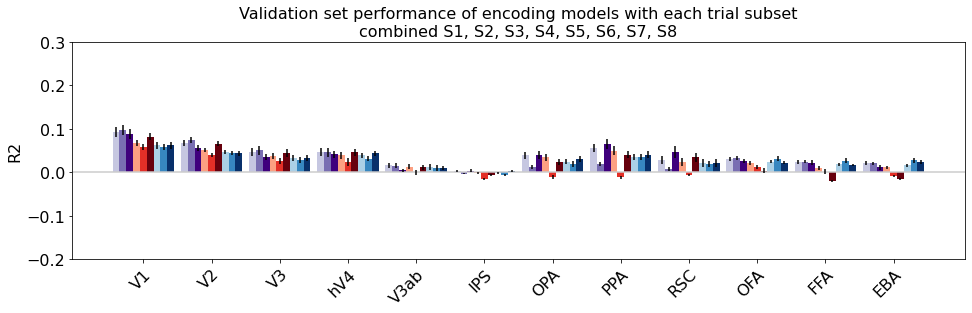

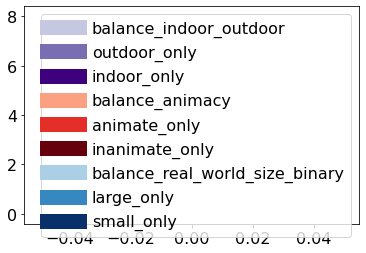

In [6]:
colors = np.concatenate([cm.Purples(np.linspace(0,1,4))[1:,:], \
                        cm.Reds(np.linspace(0,1,4))[1:,:], \
                        cm.Blues(np.linspace(0,1,4))[1:,:]], axis=0)

vals = np.zeros((n_subjects, n_rois, n_trial_subsets))

for ti in range(n_trial_subsets):

    gi = group_inds[ti]
    
    for si, ss in enumerate(subjects):

        val_r2 = out[ti][si]['val_r2'][:,0]    
       
        for ri in range(n_rois):

            inds_this_roi = roi_def.ss_roi_defs[si].get_indices(ri)
           
            vals[si,ri,ti] = np.mean(val_r2[inds_this_roi])

mean_vals = np.mean(vals, axis=0)
sem_vals = np.std(vals, axis=0) / np.sqrt(n_subjects)

legend_separate=True
title='Validation set performance of encoding models with each trial subset\n%s'%summary_plots.get_substr(out[0])
plt.rcParams['pdf.fonttype']=42

plot_utils.set_all_font_sizes(fs = 16)
bw = 0.10;
space = (1 - (bw*mean_vals.shape[1]))/2
fh = plot_utils.plot_multi_bars(mean_data=mean_vals, err_data=sem_vals, colors=colors, space=space, \
                xticklabels=roi_names, ylabel='R2', \
                ylim=[-0.20, 0.30], title=title, horizontal_line_pos=0,\
                legend_labels=np.array(trial_subsets), \
                legend_overlaid=False, legend_separate=True, \
                fig_size=(16,4))

#### Plot R2, after thresholding

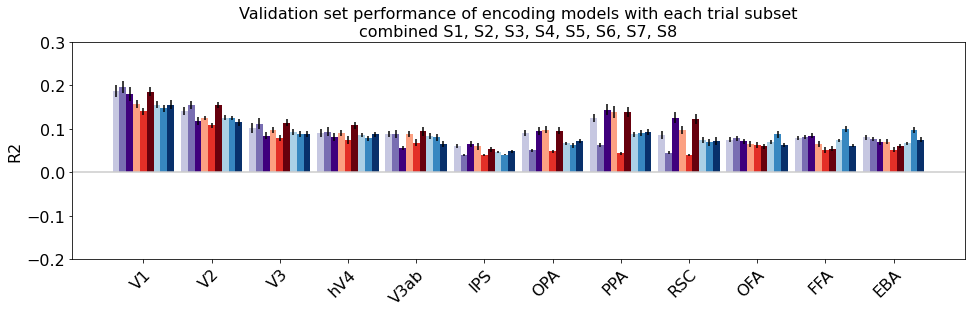

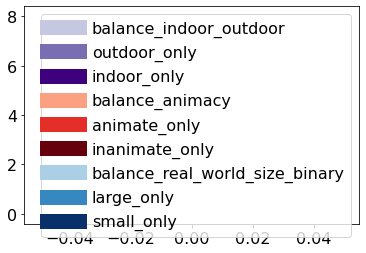

In [7]:
colors = np.concatenate([cm.Purples(np.linspace(0,1,4))[1:,:], \
                        cm.Reds(np.linspace(0,1,4))[1:,:], \
                        cm.Blues(np.linspace(0,1,4))[1:,:]], axis=0)

vals = np.zeros((n_subjects, n_rois, n_trial_subsets))

for ti in range(n_trial_subsets):

    gi = group_inds[ti]
    
    for si, ss in enumerate(subjects):

        val_r2 = out[ti][si]['val_r2'][:,0]    
       
        for ri in range(n_rois):

            inds_this_roi = roi_def.ss_roi_defs[si].get_indices(ri) & voxels_use[gi][si]
        
            vals[si,ri,ti] = np.mean(val_r2[inds_this_roi])

mean_vals = np.mean(vals, axis=0)
sem_vals = np.std(vals, axis=0) / np.sqrt(n_subjects)

legend_separate=True
title='Validation set performance of encoding models with each trial subset\n%s'%summary_plots.get_substr(out[0])
plt.rcParams['pdf.fonttype']=42

plot_utils.set_all_font_sizes(fs = 16)
bw = 0.10;
space = (1 - (bw*mean_vals.shape[1]))/2
fh = plot_utils.plot_multi_bars(mean_data=mean_vals, err_data=sem_vals, colors=colors, space=space, \
                xticklabels=roi_names, ylabel='R2', \
                ylim=[-0.20, 0.30], title=title, horizontal_line_pos=0,\
                legend_labels=np.array(trial_subsets), \
                legend_overlaid=False, legend_separate=True, \
                fig_size=(16,4))

#### organizing the feature selectivity values for each voxel

In [8]:
# matrix [n_voxels_total x n_channels x n_trial_subsets]
feature_corr = np.moveaxis(np.array([np.concatenate([out[fi][si]['corr_each_feature'] \
                                for si in range(n_subjects)], axis=0) \
                for fi in range(n_trial_subsets)]), [0,1,2], [2,0,1])

n_voxels = feature_corr.shape[0]
allcorr_reshaped = np.reshape(feature_corr, [n_voxels, n_ori, n_sf, n_trial_subsets], order='F')
mean_orient_corr = np.mean(allcorr_reshaped, axis=2)
mean_sf_corr = np.mean(allcorr_reshaped, axis=1)

# find maxes. if they are constant across orient/SF, then set to nan.
preferred_ori_corr = np.argmax(mean_orient_corr, axis=1).astype(np.float32)
is_constant = np.all(np.tile(mean_orient_corr[:,0:1,:], [1,n_ori,1])==mean_orient_corr, axis=1)
preferred_ori_corr[is_constant] = np.nan

preferred_sf_corr = np.argmax(mean_sf_corr, axis=1).astype(np.float32)
is_constant = np.all(np.tile(mean_sf_corr[:,0:1,:], [1,n_sf,1])==mean_sf_corr, axis=1)
preferred_sf_corr[is_constant] = np.nan

#### How similar is selectivity profile across different categories?
Compare levels of each semantic axis - indoor only vs outdoor only, etc

In [10]:
corr_between_methods = np.zeros((n_voxels, n_groups))
compare_names = [[] for gi in range(n_groups)]
for gi, group in enumerate(subsets2group):
    ti1 = group[1]; ti2 = group[2];
    print([ti1, ti2])
    compare_names[gi] = '%s vs. %s'%(trial_subsets[ti1], trial_subsets[ti2])
    
    corr_between_methods[:,gi] = np.array([np.corrcoef(feature_corr[vv,:,ti1], \
                                                 feature_corr[vv,:,ti2])[0,1] \
                                 for vv in range(n_voxels)])

[1, 2]
[4, 5]
[7, 8]


In [11]:
# Averaging these values within ROI

n_vox_each_subj = [out[0][si]['best_params'][0].shape[0] for si in range(n_subjects)]
subject_inds = np.concatenate([si*np.ones((n_vox_each_subj[si],),dtype=int) \
                               for si in range(n_subjects)], axis=0)

avg_corr_bw_methods = np.zeros((n_rois, n_subjects, n_groups))
for rr in range(n_rois):
    for ss in range(n_subjects):
        for gi in range(n_groups):
            inds_this_roi = roi_def.get_indices(rr) \
                & (subject_inds==ss) \
                & np.concatenate([voxels_use[gi][si] for si in range(n_subjects)], axis=0)
           
            avg_corr_bw_methods[rr,ss,gi] = \
                np.mean(corr_between_methods[inds_this_roi,gi], axis=0)

#### make a summary plot of the correlation coefficients

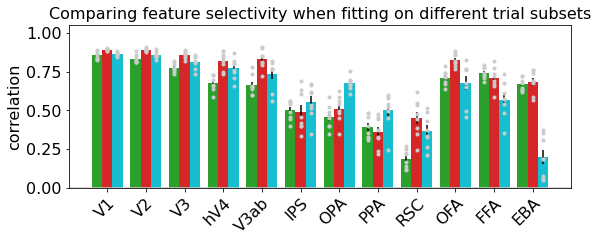

In [14]:
mean_vals = np.mean(avg_corr_bw_methods, axis=1)
sem_vals = np.std(avg_corr_bw_methods, axis=1)/np.sqrt(n_subjects)

colors = cm.tab10(np.linspace(0,1,10))[[2, 3, 9],:]

names = ['indoor only vs. outdoor only']
plt.rcParams['pdf.fonttype']=42
fh = plot_utils.plot_multi_bars(mean_data=mean_vals, err_data=sem_vals, \
                                point_data=np.moveaxis(avg_corr_bw_methods, \
                                                       [0,1,2], [1,0,2]), \
                                space=0.1, \
                xticklabels=roi_names, ylabel='correlation', \
                ylim=[0,1.05], title='Comparing feature selectivity when fitting on different trial subsets',\
                colors=colors, \
                fig_size=(9,3), 
                legend_separate=False, 
                legend_labels=compare_names)

fn2save = '/user_data/mmhender/imStat/figures/Similarity_featuretuning_acrosscategory.pdf'
plt.savefig(fn2save)


#### Plot histograms of similarity in feature selectivity, across methods

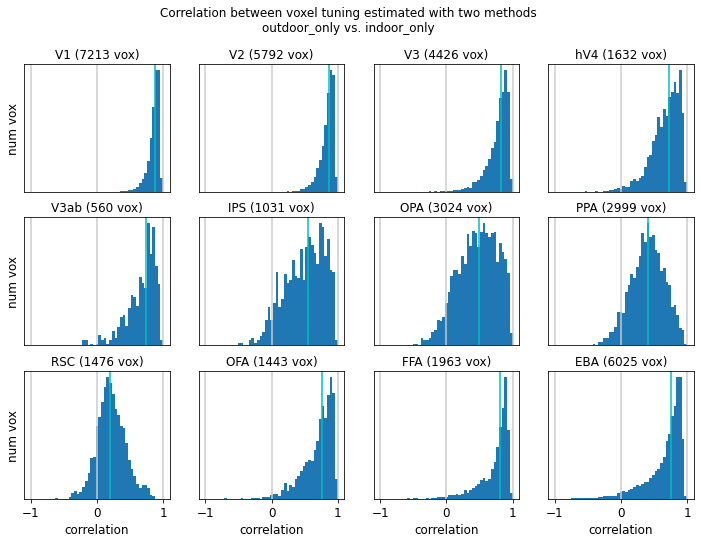

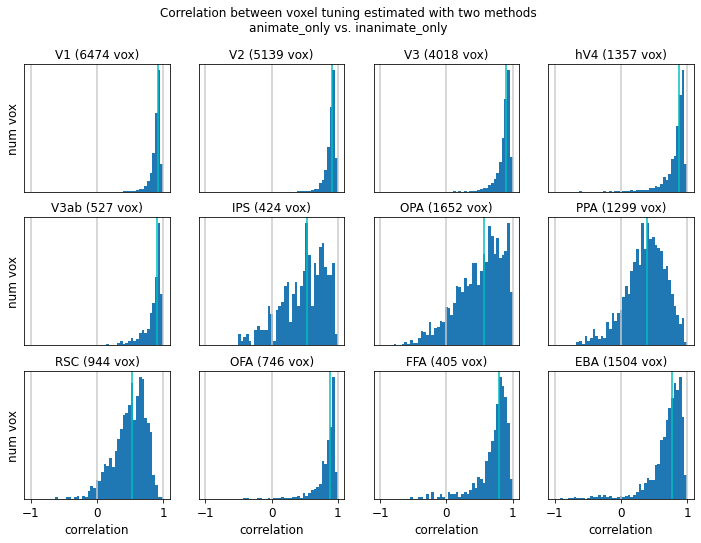

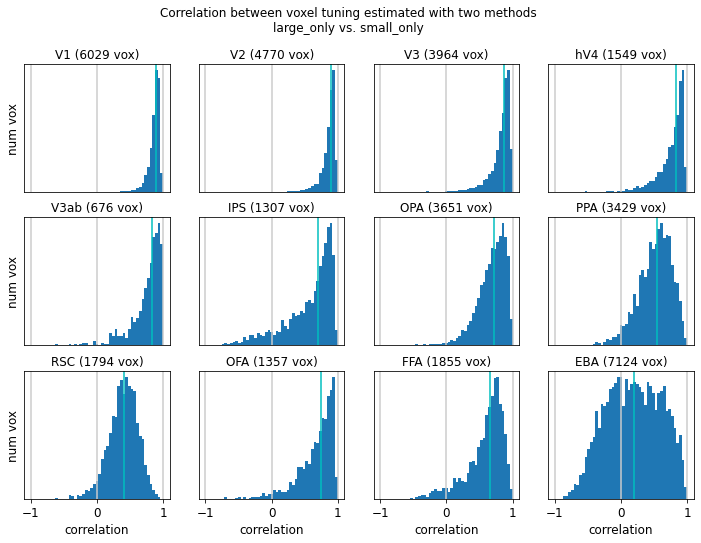

In [104]:
plot_utils.set_all_font_sizes(12)

plt.rcParams['pdf.fonttype']=42

for gi in range(n_groups):

    plt.figure(figsize=(12,8))
    npy = int(np.ceil(np.sqrt(n_rois)))
    npx = int(np.ceil((n_rois)/npy))

    pi=0
    for ri in range(n_rois):

        inds_this_roi = roi_def.get_indices(ri) & \
            np.concatenate([voxels_use[gi][si] for si in range(n_subjects)], axis=0)
        vals = corr_between_methods[inds_this_roi,gi]
        

        pi+=1
        plt.subplot(npx,npy,pi)

        bins = np.linspace(-1,1,50)
        plt.hist(vals,bins=bins)
        plt.axvline(np.median(vals),color='c')
        plt.xlim([-1.1, 1.1])
        plt.axvline(1.0, color=[0.8, 0.8, 0.8])
        plt.axvline(-0.0, color=[0.8, 0.8, 0.8])
        plt.axvline(-1.0, color=[0.8, 0.8, 0.8])
        if np.mod(pi, npy)==1:
            plt.ylabel('num vox')
        plt.yticks([])
        if pi>=(npx-1)*npy+1:
            plt.xlabel('correlation')
        else:
            plt.xticks([]);

        plt.title('%s (%d vox)'%(roi_names[ri], np.sum(inds_this_roi)))

    plt.suptitle('Correlation between voxel tuning estimated with two methods\n%s'\
                 %(compare_names[gi]));

In [29]:
# stuff for plots

roi_groups = [[0,1,2,3],[4,5],[6,7,8],[9,10],[11]]
n_roi_groups = len(roi_groups)
# colors = np.tile([[0.6, 0.6, 0.6],],[5,1])
colors = ['#7f7f7f', '#7f7f7f', '#7f7f7f', '#7f7f7f', '#7f7f7f']
# colors = ['#0071bc',  '#f15a24', '#006837', '#c1272d', '#662d91']
roi_color_inds = [np.where([ri in rg for rg in roi_groups])[0][0] for ri in range(n_rois)]


#### Plot distributions of preferred orientation

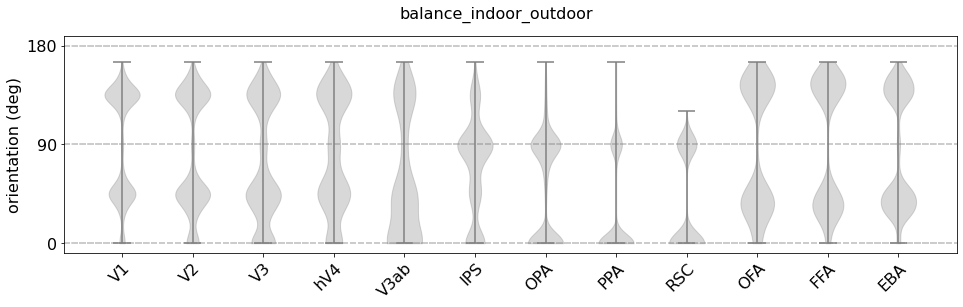

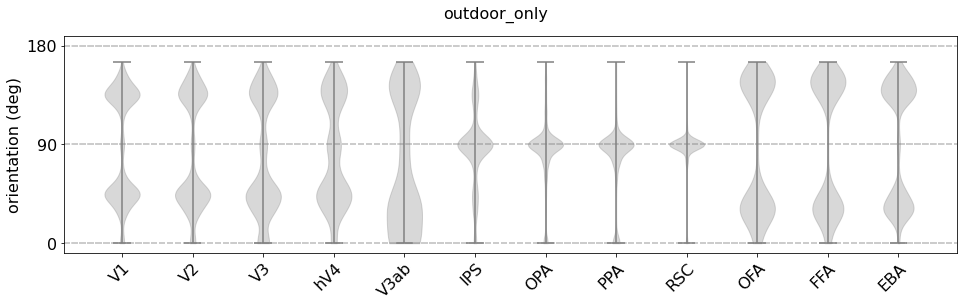

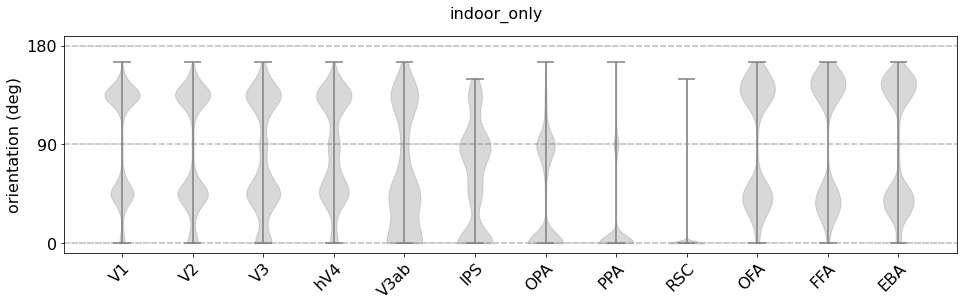

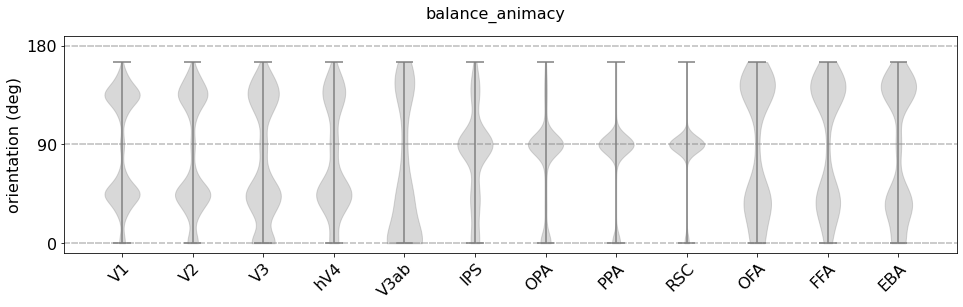

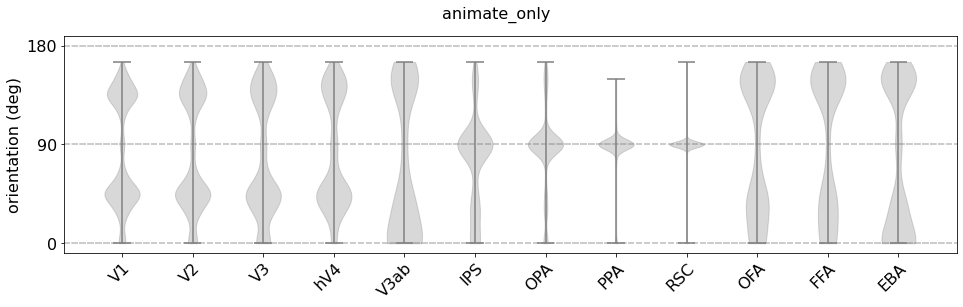

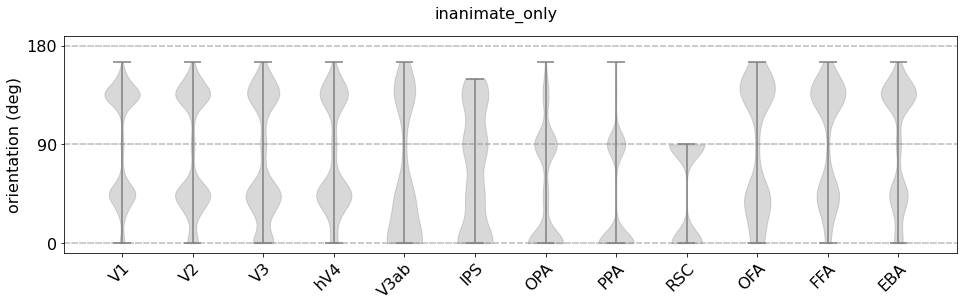

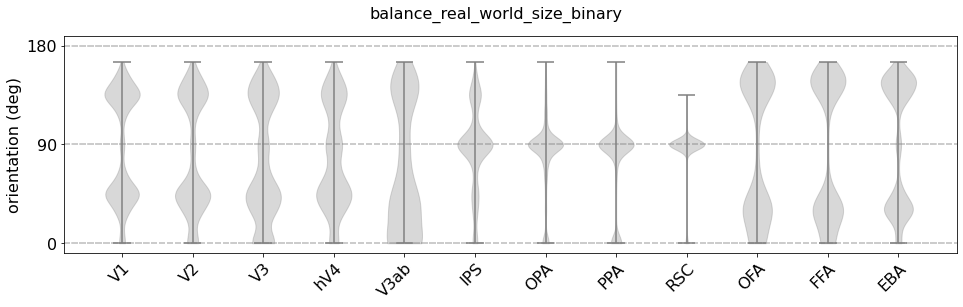

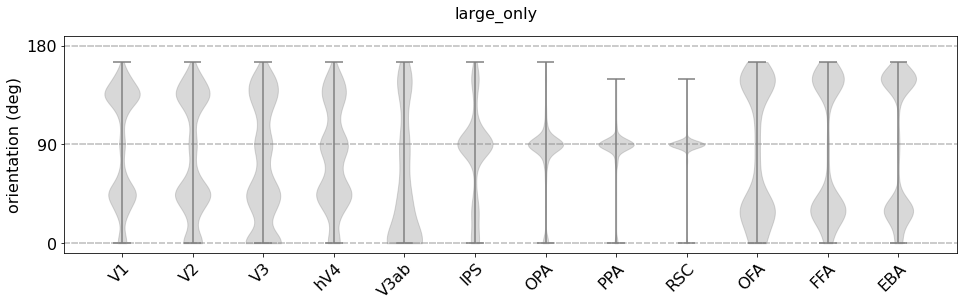

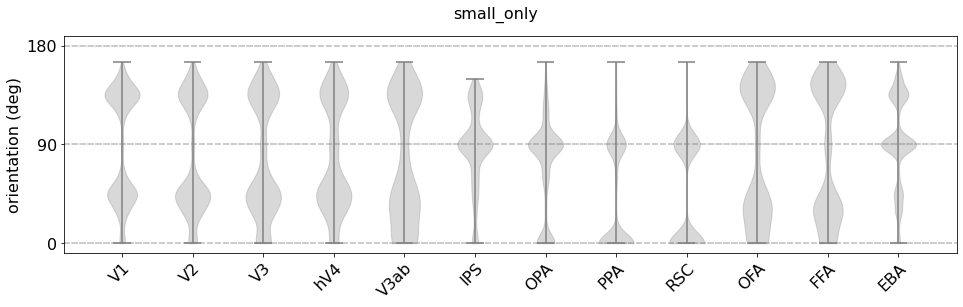

In [30]:

for ti in range(n_trial_subsets):

    gi = [gi for gi in range(3) if ti in subsets2group[gi]][0]
   
    plot_utils.set_all_font_sizes(16)

    plt.rcParams['pdf.fonttype']=42

    color = [0.6, 0.6, 0.6]

    plt.figure(figsize=(16,4))

    for ri in range(n_rois):
        
        color = colors[roi_color_inds[ri]]

        inds_this_roi = roi_def.get_indices(ri) & \
            np.concatenate([voxels_use[gi][si] for si in range(n_subjects)], axis=0)
           
        parts = plt.violinplot(ori_unique[preferred_ori_corr[inds_this_roi,ti].astype(int)],[ri])
        for pc in parts['bodies']:
            pc.set_color(color)
        parts['cbars'].set_color(color)
        parts['cmins'].set_color(color)
        parts['cmaxes'].set_color(color)

        plt.yticks([0,90,180])
        plt.axhline(0,linestyle='--',color=[0.8, 0.8, 0.8],zorder=-10)
        plt.axhline(90,linestyle='--',color=[0.8, 0.8, 0.8],zorder=-10)
        plt.axhline(180,linestyle='--',color=[0.8, 0.8, 0.8],zorder=-10)

        plt.ylabel('orientation (deg)')

        plt.axhline(0,linestyle='--',color=[0.8, 0.8, 0.8],zorder=-10)

    plt.xticks(ticks=np.arange(0,n_rois),labels=roi_names,\
                           rotation=45, ha='right',rotation_mode='anchor')

    plt.suptitle('%s'%trial_subsets[ti])

    # fn2save = '/user_data/mmhender/imStat/figures/Gabor_orient_violin.pdf'
    # plt.savefig(fn2save)

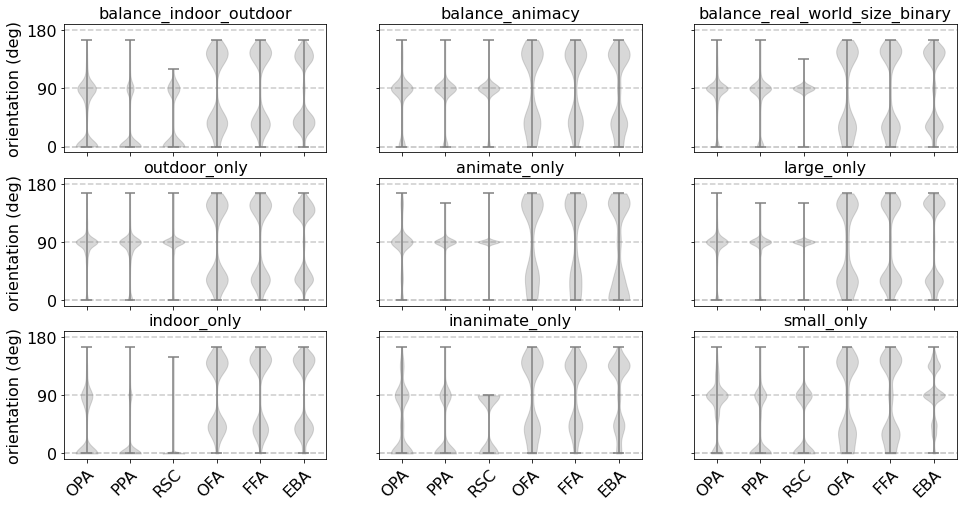

In [31]:
plot_utils.set_all_font_sizes(16)

plt.rcParams['pdf.fonttype']=42

rois2plot = [6,7,8,9,10,11]
plot_inds = [0,3,6,1,4,7,2,5,8]

plt.figure(figsize=(16,8))

for ti in range(n_trial_subsets):

    gi = [gi for gi in range(3) if ti in subsets2group[gi]][0]
   
    plt.subplot(3,3,plot_inds[ti]+1)
    
    for ri, rr in enumerate(rois2plot):
        
        color = colors[roi_color_inds[rr]]

        inds_this_roi = roi_def.get_indices(rr) & \
            np.concatenate([voxels_use[gi][si] for si in range(n_subjects)], axis=0)
           
        parts = plt.violinplot(ori_unique[preferred_ori_corr[inds_this_roi,ti].astype(int)],[ri])
        for pc in parts['bodies']:
            pc.set_color(color)
        parts['cbars'].set_color(color)
        parts['cmins'].set_color(color)
        parts['cmaxes'].set_color(color)

    
    plt.axhline(0,linestyle='--',color=[0.8, 0.8, 0.8],zorder=-10)
    plt.axhline(90,linestyle='--',color=[0.8, 0.8, 0.8],zorder=-10)
    plt.axhline(180,linestyle='--',color=[0.8, 0.8, 0.8],zorder=-10)

    if np.mod(plot_inds[ti],3)==0:
        plt.ylabel('orientation (deg)')
        plt.yticks([0,90,180])
    else:
        plt.yticks([0,90,180], labels=[])
        
    plt.axhline(0,linestyle='--',color=[0.8, 0.8, 0.8],zorder=-10)

    if plot_inds[ti]>5:
        plt.xticks(ticks=np.arange(0,len(rois2plot)),labels=np.array(roi_names)[rois2plot],\
                           rotation=45, ha='right',rotation_mode='anchor')
    else:
        plt.xticks(ticks=np.arange(0,len(rois2plot)),labels=[])
        
    plt.title('%s'%trial_subsets[ti])

fn2save = '/user_data/mmhender/imStat/figures/Gabor_orient_violin_trialsubsets.pdf'
plt.savefig(fn2save)

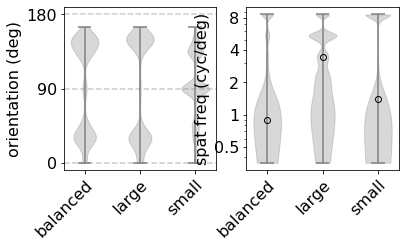

In [33]:
rr = 11;
color = colors[roi_color_inds[rr]]

gi = 2;
inds_this_roi = roi_def.get_indices(rr) & \
            np.concatenate([voxels_use[gi][si] for si in range(n_subjects)], axis=0)
   
names = ['balanced', 'large', 'small']
groupname = trial_subsets[subsets2group[gi][0]].split('balance_')[1]
                                                      
plt.figure(figsize=(6,3))

plt.subplot(1,2,1);

for ti, tt in enumerate(subsets2group[gi]):

    parts = plt.violinplot(ori_unique[preferred_ori_corr[inds_this_roi,tt].astype(int)],[ti])
    for pc in parts['bodies']:
        pc.set_color(color)
    parts['cbars'].set_color(color)
    parts['cmins'].set_color(color)
    parts['cmaxes'].set_color(color)

plt.axhline(0,linestyle='--',color=[0.8, 0.8, 0.8],zorder=-10)
plt.axhline(90,linestyle='--',color=[0.8, 0.8, 0.8],zorder=-10)
plt.axhline(180,linestyle='--',color=[0.8, 0.8, 0.8],zorder=-10)
plt.ylabel('orientation (deg)')
plt.yticks([0,90,180]);

plt.xticks(ticks=np.arange(0,len(subsets2group[gi])),\
                       labels=names,\
                       rotation=45, ha='right',rotation_mode='anchor');

plt.subplot(1,2,2);

for ti, tt in enumerate(subsets2group[gi]):

    vals = sf_unique[preferred_sf_corr[inds_this_roi,tt].astype(int)]
    parts = plt.violinplot(vals,[ti])
    for pc in parts['bodies']:
        pc.set_color(color)
    parts['cbars'].set_color(color)
    parts['cmins'].set_color(color)
    parts['cmaxes'].set_color(color)
    plt.plot(ti, np.median(vals),'o',color='k',markerfacecolor='none')

plt.yticks([0,4,8])
plt.gca().set_yscale('log')
plt.yticks([10**np.log10(0.5), 10**np.log10(1), \
        10**np.log10(2),10**np.log10(4), \
        10**np.log10(8)],\
       [0.5,1,2,4,8])
plt.ylabel('spat freq (cyc/deg)')

plt.axhline(0,linestyle='--',color=[0.8, 0.8, 0.8],zorder=-10)


plt.xticks(ticks=np.arange(0,len(subsets2group[gi])),\
                       labels=names,\
                       rotation=45, ha='right',rotation_mode='anchor');

fn2save = '/user_data/mmhender/imStat/figures/%s_sep_%s.pdf'%(roi_names[rr], groupname)
plt.savefig(fn2save)


['balance_animacy' 'animate_only' 'inanimate_only']


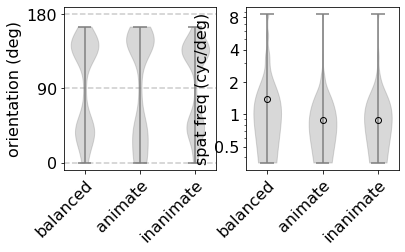

In [34]:
rr = 10;
color = colors[roi_color_inds[rr]]

gi = 1;
inds_this_roi = roi_def.get_indices(rr) & \
            np.concatenate([voxels_use[gi][si] for si in range(n_subjects)], axis=0)
   
print(np.array(trial_subsets)[subsets2group[gi]])
names = ['balanced', 'animate', 'inanimate']
groupname = trial_subsets[subsets2group[gi][0]].split('balance_')[1]
                                                      
plt.figure(figsize=(6,3))

plt.subplot(1,2,1);

for ti, tt in enumerate(subsets2group[gi]):

    parts = plt.violinplot(ori_unique[preferred_ori_corr[inds_this_roi,tt].astype(int)],[ti])
    for pc in parts['bodies']:
        pc.set_color(color)
    parts['cbars'].set_color(color)
    parts['cmins'].set_color(color)
    parts['cmaxes'].set_color(color)

plt.axhline(0,linestyle='--',color=[0.8, 0.8, 0.8],zorder=-10)
plt.axhline(90,linestyle='--',color=[0.8, 0.8, 0.8],zorder=-10)
plt.axhline(180,linestyle='--',color=[0.8, 0.8, 0.8],zorder=-10)
plt.ylabel('orientation (deg)')
plt.yticks([0,90,180]);

plt.xticks(ticks=np.arange(0,len(subsets2group[gi])),\
                       labels=names,\
                       rotation=45, ha='right',rotation_mode='anchor');

plt.subplot(1,2,2);

for ti, tt in enumerate(subsets2group[gi]):

    vals = sf_unique[preferred_sf_corr[inds_this_roi,tt].astype(int)]
    parts = plt.violinplot(vals,[ti])
    for pc in parts['bodies']:
        pc.set_color(color)
    parts['cbars'].set_color(color)
    parts['cmins'].set_color(color)
    parts['cmaxes'].set_color(color)
    plt.plot(ti, np.median(vals),'o',color='k',markerfacecolor='none')

plt.yticks([0,4,8])

plt.ylabel('spat freq (cyc/deg)')
plt.gca().set_yscale('log')
plt.yticks([10**np.log10(0.5), 10**np.log10(1), \
        10**np.log10(2),10**np.log10(4), \
        10**np.log10(8)],\
       [0.5,1,2,4,8])
plt.axhline(0,linestyle='--',color=[0.8, 0.8, 0.8],zorder=-10)


plt.xticks(ticks=np.arange(0,len(subsets2group[gi])),\
                       labels=names,\
                       rotation=45, ha='right',rotation_mode='anchor');

fn2save = '/user_data/mmhender/imStat/figures/%s_sep_%s.pdf'%(roi_names[rr], groupname)
plt.savefig(fn2save)


['balance_indoor_outdoor' 'outdoor_only' 'indoor_only']
/user_data/mmhender/imStat/figures/PPA_sep_indoor_outdoor.pdf


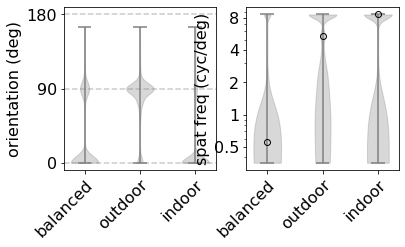

In [35]:
rr = 7;
color = colors[roi_color_inds[rr]]

plt.rcParams['pdf.fonttype']=42

gi = 0;
inds_this_roi = roi_def.get_indices(rr) & \
            np.concatenate([voxels_use[gi][si] for si in range(n_subjects)], axis=0)
   
print(np.array(trial_subsets)[subsets2group[gi]])
names = ['balanced', 'outdoor', 'indoor']
groupname = trial_subsets[subsets2group[gi][0]].split('balance_')[1]
                                                      
plt.figure(figsize=(6,3))

plt.subplot(1,2,1);

for ti, tt in enumerate(subsets2group[gi]):

    parts = plt.violinplot(ori_unique[preferred_ori_corr[inds_this_roi,tt].astype(int)],[ti])
    for pc in parts['bodies']:
        pc.set_color(color)
    parts['cbars'].set_color(color)
    parts['cmins'].set_color(color)
    parts['cmaxes'].set_color(color)

plt.axhline(0,linestyle='--',color=[0.8, 0.8, 0.8],zorder=-10)
plt.axhline(90,linestyle='--',color=[0.8, 0.8, 0.8],zorder=-10)
plt.axhline(180,linestyle='--',color=[0.8, 0.8, 0.8],zorder=-10)
plt.ylabel('orientation (deg)')
plt.yticks([0,90,180]);

plt.xticks(ticks=np.arange(0,len(subsets2group[gi])),\
                       labels=names,\
                       rotation=45, ha='right',rotation_mode='anchor');

plt.subplot(1,2,2);

for ti, tt in enumerate(subsets2group[gi]):

    vals = sf_unique[preferred_sf_corr[inds_this_roi,tt].astype(int)]
    parts = plt.violinplot(vals,[ti])
    for pc in parts['bodies']:
        pc.set_color(color)
    parts['cbars'].set_color(color)
    parts['cmins'].set_color(color)
    parts['cmaxes'].set_color(color)
    plt.plot(ti, np.median(vals),'o',color='k',markerfacecolor='none')

plt.yticks([0,4,8])

plt.ylabel('spat freq (cyc/deg)')
plt.gca().set_yscale('log')
plt.yticks([10**np.log10(0.5), 10**np.log10(1), \
                10**np.log10(2),10**np.log10(4), \
                10**np.log10(8)],\
               [0.5,1,2,4,8])

plt.axhline(0,linestyle='--',color=[0.8, 0.8, 0.8],zorder=-10)


plt.xticks(ticks=np.arange(0,len(subsets2group[gi])),\
                       labels=names,\
                       rotation=45, ha='right',rotation_mode='anchor');

fn2save = '/user_data/mmhender/imStat/figures/%s_sep_%s.pdf'%(roi_names[rr], groupname)
print(fn2save)
plt.savefig(fn2save)


In [166]:
fn2save

'/user_data/mmhender/imStat/figures/RSC_sep_indoor_outdoor.pdf'

#### Plot distributions of preferred frequency

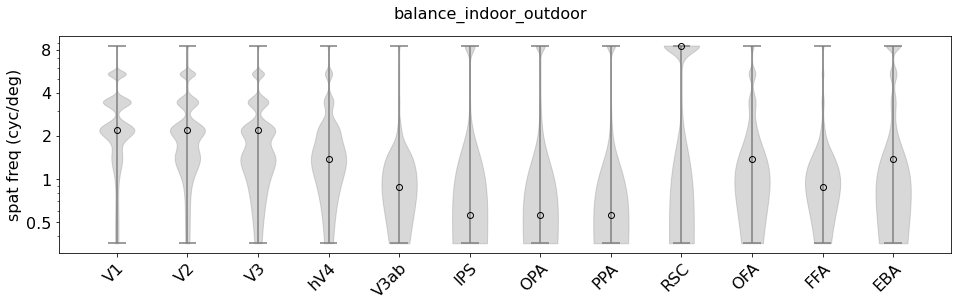

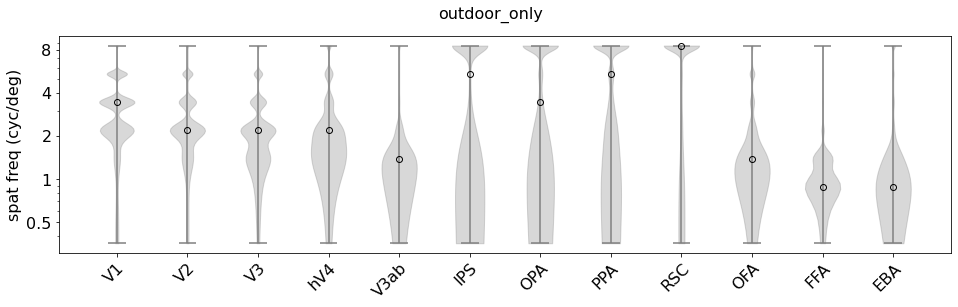

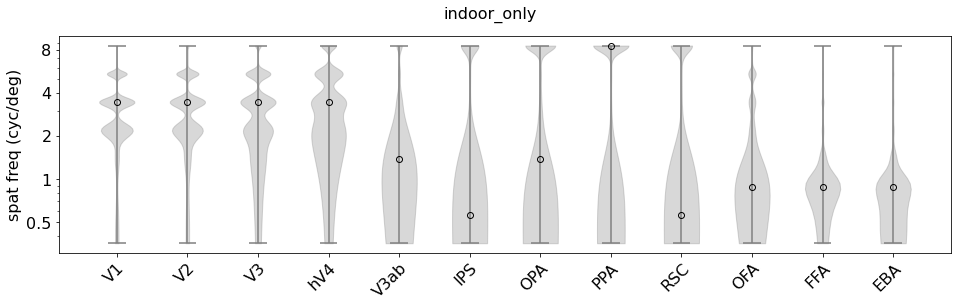

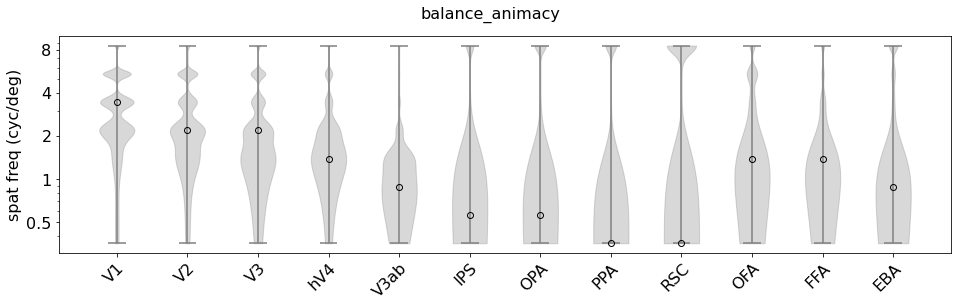

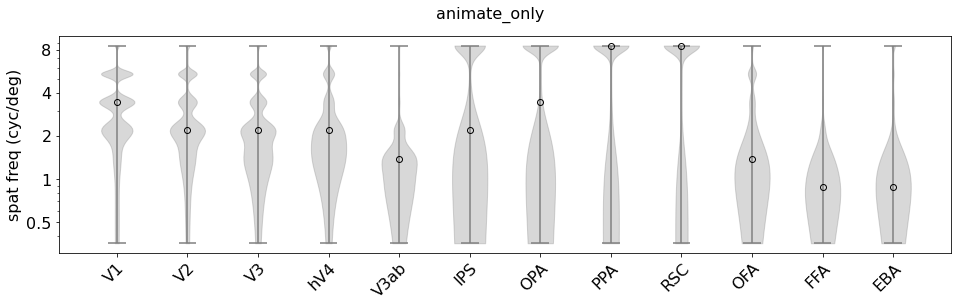

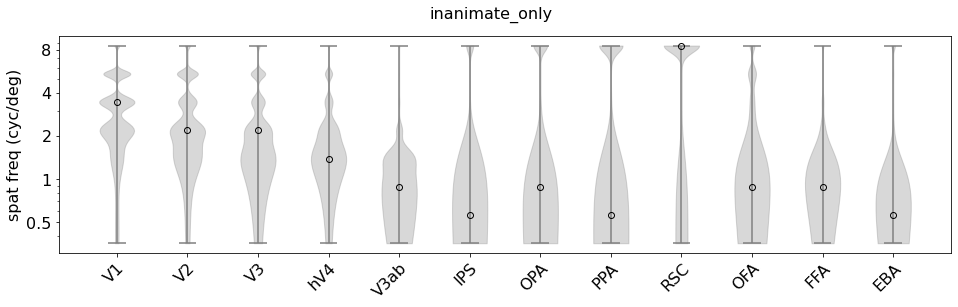

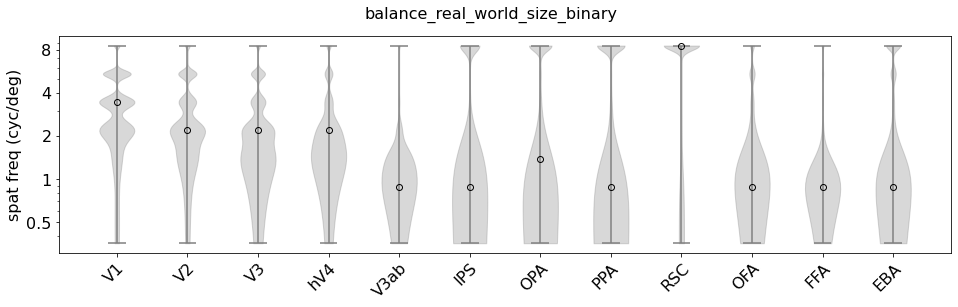

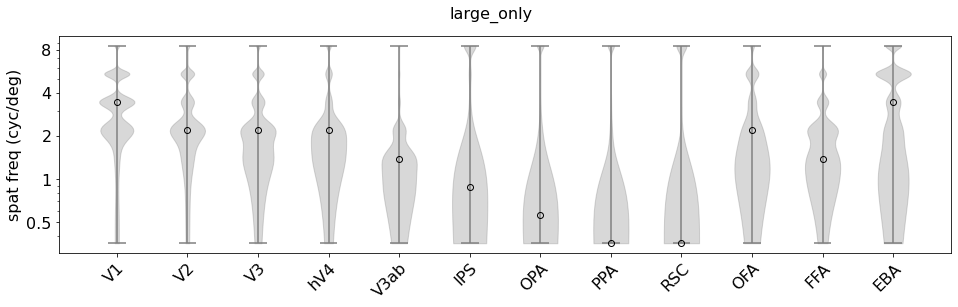

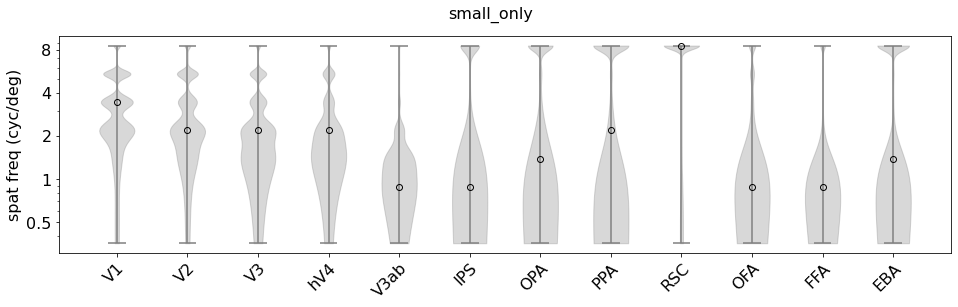

In [36]:
for ti in range(n_trial_subsets):

    gi = [gi for gi in range(3) if ti in subsets2group[gi]][0]
    # print(gi)
    
    plot_utils.set_all_font_sizes(16)

    plt.rcParams['pdf.fonttype']=42

    plt.figure(figsize=(16,4))

    for ri in range(n_rois):
        
        color = colors[roi_color_inds[ri]]

        inds_this_roi = roi_def.get_indices(ri) & \
            np.concatenate([voxels_use[gi][si] for si in range(n_subjects)], axis=0)
           
        vals = sf_unique[preferred_sf_corr[inds_this_roi,ti].astype(int)]
        parts = plt.violinplot(vals,[ri])
        for pc in parts['bodies']:
            pc.set_color(color)
        parts['cbars'].set_color(color)
        parts['cmins'].set_color(color)
        parts['cmaxes'].set_color(color)
        plt.plot(ri, np.median(vals),'o',color='k',markerfacecolor='none')

        plt.yticks([0,4,8])

        plt.ylabel('spat freq (cyc/deg)')
        plt.gca().set_yscale('log')
        plt.yticks([10**np.log10(0.5), 10**np.log10(1), \
                10**np.log10(2),10**np.log10(4), \
                10**np.log10(8)],\
               [0.5,1,2,4,8])
        plt.axhline(0,linestyle='--',color=[0.8, 0.8, 0.8],zorder=-10)

    plt.xticks(ticks=np.arange(0,n_rois),labels=roi_names,\
                           rotation=45, ha='right',rotation_mode='anchor')

    plt.suptitle('%s'%trial_subsets[ti])

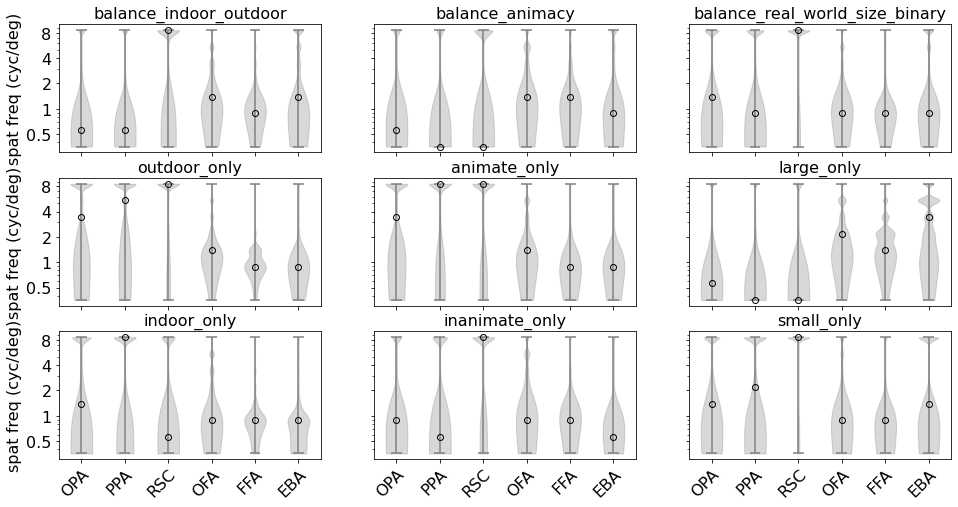

In [37]:
plot_utils.set_all_font_sizes(16)

plt.rcParams['pdf.fonttype']=42

rois2plot = [6,7,8,9,10,11]
plot_inds = [0,3,6,1,4,7,2,5,8]

plt.figure(figsize=(16,8))

for ti in range(n_trial_subsets):

    gi = [gi for gi in range(3) if ti in subsets2group[gi]][0]
   
    plt.subplot(3,3,plot_inds[ti]+1)
    
    for ri, rr in enumerate(rois2plot):
        
        color = colors[roi_color_inds[rr]]

        inds_this_roi = roi_def.get_indices(rr) & \
            np.concatenate([voxels_use[gi][si] for si in range(n_subjects)], axis=0)
           
        vals = sf_unique[preferred_sf_corr[inds_this_roi,ti].astype(int)]
        parts = plt.violinplot(vals,[ri])
        for pc in parts['bodies']:
            pc.set_color(color)
        parts['cbars'].set_color(color)
        parts['cmins'].set_color(color)
        parts['cmaxes'].set_color(color)
        plt.plot(ri, np.median(vals),'o',color='k',markerfacecolor='none')

    plt.gca().set_yscale('log')
    if np.mod(plot_inds[ti],3)==0:
        plt.ylabel('spat freq (cyc/deg)')

        plt.yticks([10**np.log10(0.5), 10**np.log10(1), \
                10**np.log10(2),10**np.log10(4), \
                10**np.log10(8)],\
               [0.5,1,2,4,8])

        
    else:
        plt.yticks([10**np.log10(0.5), 10**np.log10(1), \
                10**np.log10(2),10**np.log10(4), \
                10**np.log10(8)],\
               [])

        
    plt.axhline(0,linestyle='--',color=[0.8, 0.8, 0.8],zorder=-10)

    if plot_inds[ti]>5:
        plt.xticks(ticks=np.arange(0,len(rois2plot)),labels=np.array(roi_names)[rois2plot],\
                           rotation=45, ha='right',rotation_mode='anchor')
    else:
        plt.xticks(ticks=np.arange(0,len(rois2plot)),labels=[])
        
    plt.title('%s'%trial_subsets[ti])

fn2save = '/user_data/mmhender/imStat/figures/Gabor_freq_violin_trialsubsets.pdf'
plt.savefig(fn2save)

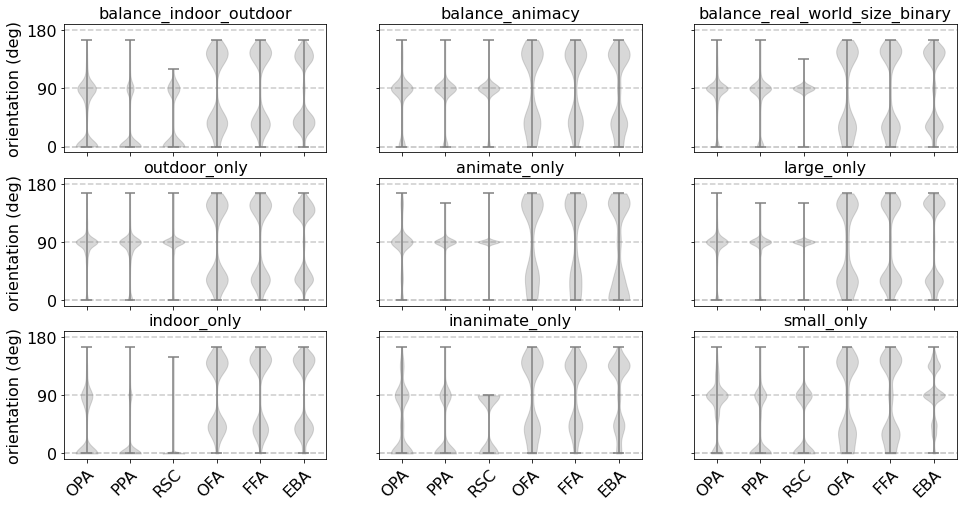

In [38]:
plot_utils.set_all_font_sizes(16)

plt.rcParams['pdf.fonttype']=42

rois2plot = [6,7,8,9,10,11]
plot_inds = [0,3,6,1,4,7,2,5,8]

plt.figure(figsize=(16,8))

for ti in range(n_trial_subsets):

    gi = [gi for gi in range(3) if ti in subsets2group[gi]][0]
   
    plt.subplot(3,3,plot_inds[ti]+1)
    
    for ri, rr in enumerate(rois2plot):
        
        color = colors[roi_color_inds[rr]]

        inds_this_roi = roi_def.get_indices(rr) & \
            np.concatenate([voxels_use[gi][si] for si in range(n_subjects)], axis=0)
           
        parts = plt.violinplot(ori_unique[preferred_ori_corr[inds_this_roi,ti].astype(int)],[ri])
        for pc in parts['bodies']:
            pc.set_color(color)
        parts['cbars'].set_color(color)
        parts['cmins'].set_color(color)
        parts['cmaxes'].set_color(color)

    
    plt.axhline(0,linestyle='--',color=[0.8, 0.8, 0.8],zorder=-10)
    plt.axhline(90,linestyle='--',color=[0.8, 0.8, 0.8],zorder=-10)
    plt.axhline(180,linestyle='--',color=[0.8, 0.8, 0.8],zorder=-10)

    if np.mod(plot_inds[ti],3)==0:
        plt.ylabel('orientation (deg)')
        plt.yticks([0,90,180])
    else:
        plt.yticks([0,90,180], labels=[])
        
    plt.axhline(0,linestyle='--',color=[0.8, 0.8, 0.8],zorder=-10)

    if plot_inds[ti]>5:
        plt.xticks(ticks=np.arange(0,len(rois2plot)),labels=np.array(roi_names)[rois2plot],\
                           rotation=45, ha='right',rotation_mode='anchor')
    else:
        plt.xticks(ticks=np.arange(0,len(rois2plot)),labels=[])
        
    plt.title('%s'%trial_subsets[ti])

fn2save = '/user_data/mmhender/imStat/figures/Gabor_orient_violin_trialsubsets.pdf'
plt.savefig(fn2save)

In [39]:
colors_outdoor = np.flipud(cm.Greens(np.linspace(0,1,3))[1:3,:])
colors_outdoor = np.concatenate([np.array([[0.6, 0.6, 0.6, 1]]), colors_outdoor], axis=0)

colors_animacy = np.flipud(cm.Reds(np.linspace(0,1,5))[[1,3],:])
colors_animacy = np.concatenate([np.array([[0.6, 0.6, 0.6, 1]]), colors_animacy], axis=0)

colors_size = np.flipud(cm.Blues(np.linspace(0,1,3))[1:3,:])
colors_size = np.concatenate([np.array([[0.6, 0.6, 0.6, 1]]), colors_size], axis=0)

colors_categ = [colors_outdoor, colors_animacy, colors_size]

#### Plot selectivity profiles over orientation, for each subset of trials

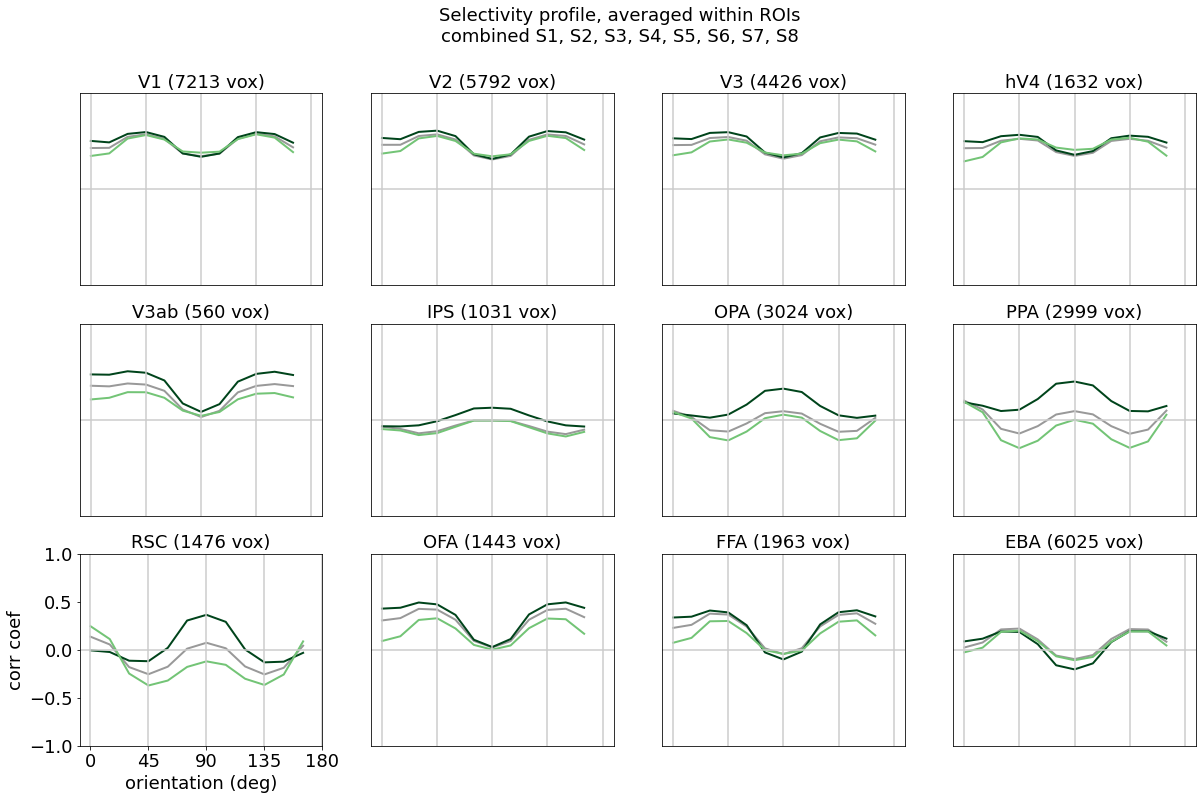

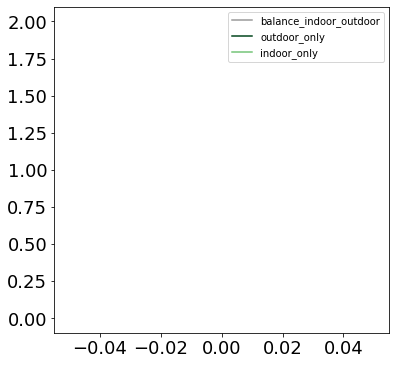

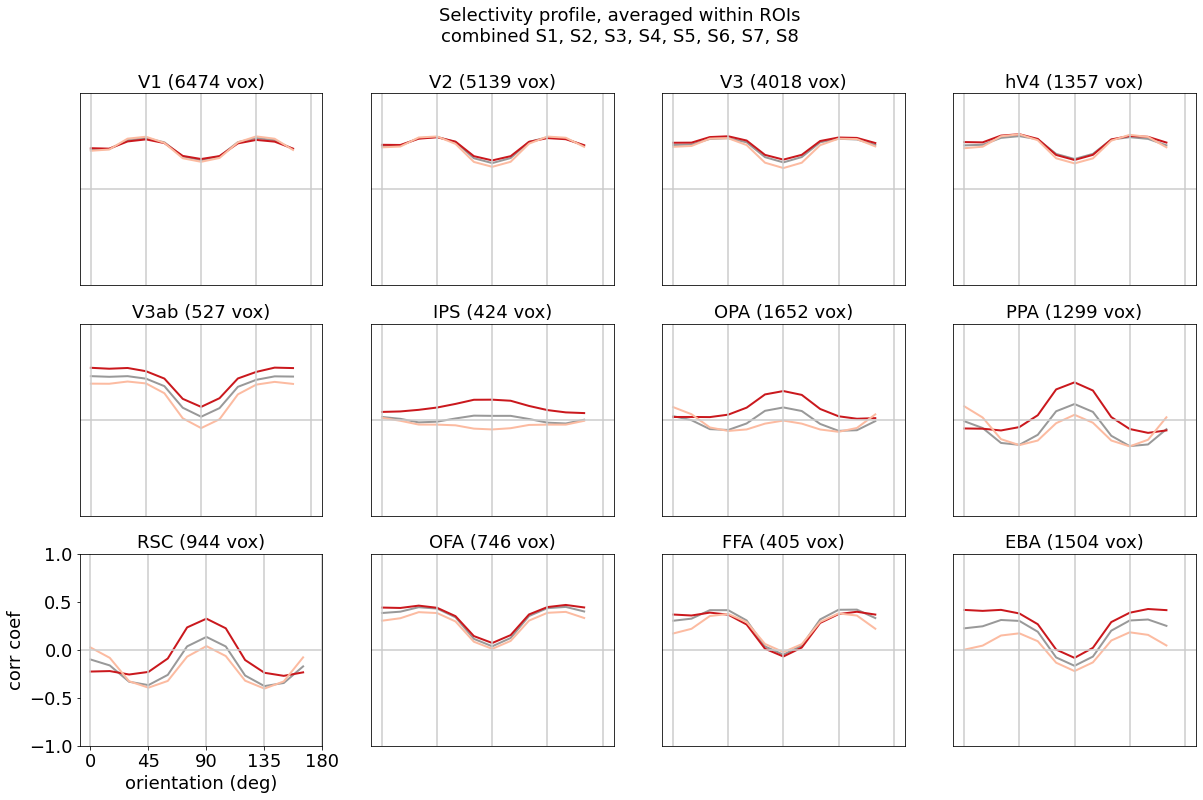

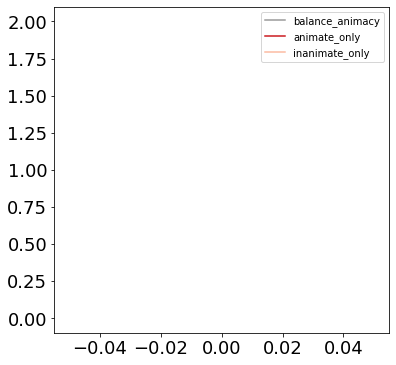

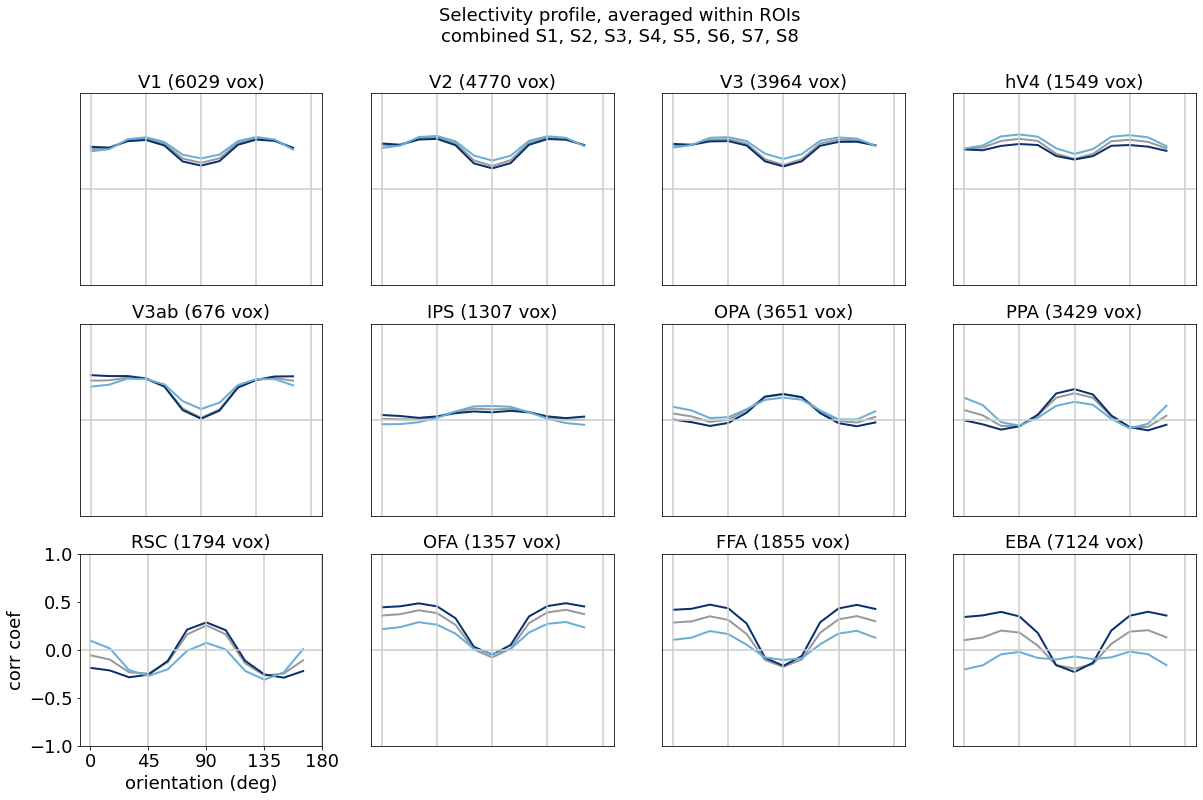

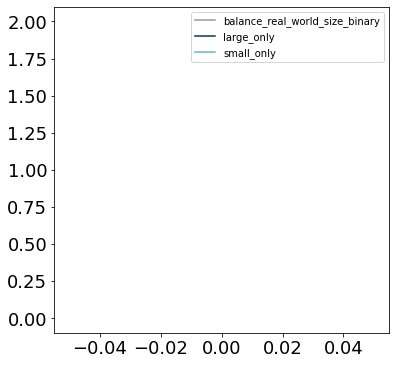

In [40]:
# Plot average orientation tuning curves for each ROI

plot_utils.set_all_font_sizes(18)
subsets2group = [[0,1,2], [3,4,5], [6,7,8]];
n_groups = 3;

for gi, group in enumerate(subsets2group):

    plt.figure(figsize=(20,12))
    npy = int(np.ceil(np.sqrt(n_rois)))
    npx = int(np.ceil((n_rois)/npy))

    colors = colors_categ[gi]
    
    for rr in range(n_rois):

        for ti, ts in enumerate(group):
 
            # indices for the voxels of interest
            inds_this_roi = roi_def.get_indices(rr) & \
                            np.concatenate([voxels_use[gi][si] for si in range(n_subjects)], axis=0)
           
            pi = rr+1;
            plt.subplot(npx,npy,pi)

            plt.plot(ori_unique,  np.mean(mean_orient_corr[inds_this_roi,:,ts], axis=0),\
                     '-',color=colors[ti,:],linewidth=2)

        plt.axhline(0, color=[0.8, 0.8, 0.8])
        plt.ylim([-1.0,1.0])

        if pi==(npx-1)*npy+1:
            plt.xlabel('orientation (deg)')
            plt.ylabel('corr coef')
            plt.xticks(np.arange(0,181,45))
        else:
            plt.xticks([]);
            plt.yticks([])

        for ii in np.arange(0,181,45):
            plt.axvline(ii,color=[0.8, 0.8, 0.8])

        plt.title('%s (%d vox)'%(roi_names[rr], np.sum(inds_this_roi)))

    plt.suptitle('Selectivity profile, averaged within ROIs\n%s'%summary_plots.get_substr(out[0]))

    # plot_utils.set_all_font_sizes(10)
    plt.figure(figsize=(6,6));
    for ti, ts in enumerate(group):
        plt.plot(0,ti,color=colors[ti,:])    
    plt.legend(['%s'%trial_subsets[ts] for ts in group], prop={'size':10})
    # plot_utils.set_all_font_sizes(16)

['balance_indoor_outdoor' 'outdoor_only' 'indoor_only']
/user_data/mmhender/imStat/figures/Profiles_PPA_sep_indoor_outdoor.pdf
['balance_animacy' 'animate_only' 'inanimate_only']
/user_data/mmhender/imStat/figures/Profiles_FFA_sep_animacy.pdf
['balance_real_world_size_binary' 'large_only' 'small_only']
/user_data/mmhender/imStat/figures/Profiles_EBA_sep_real_world_size_binary.pdf


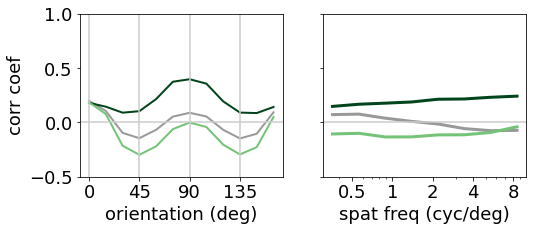

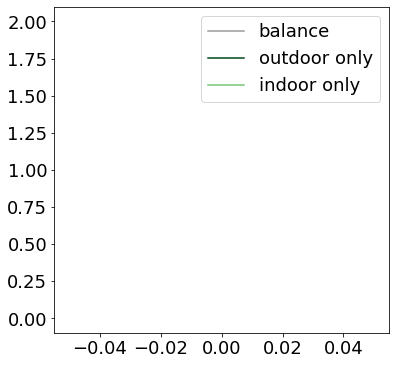

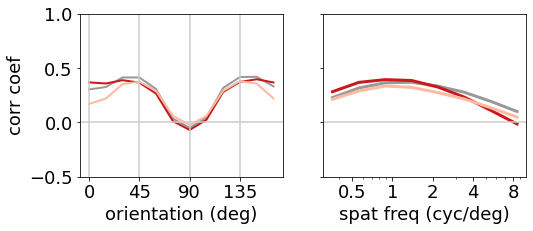

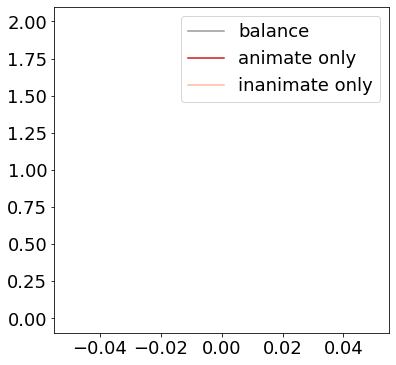

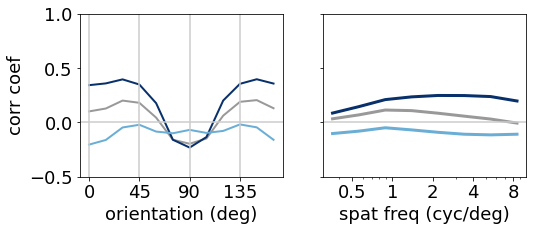

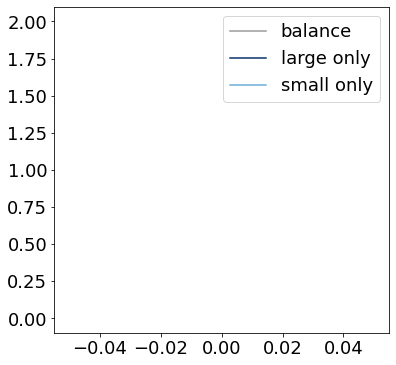

In [42]:
# Plot average orientation tuning curves for each ROI

rr2plot = [7,10,11]
gi2plot = [0,1,2]
names_list =[ ['balance', 'outdoor only', 'indoor only'], \
           ['balance', 'animate only', 'inanimate only'], \
             ['balance', 'large only', 'small only']]
plot_utils.set_all_font_sizes(18)

             
for rr, gi, names in zip(rr2plot, gi2plot, names_list):


    print(np.array(trial_subsets)[subsets2group[gi]])

    groupname = trial_subsets[subsets2group[gi][0]].split('balance_')[1]

    # indices for the voxels of interest
    inds_this_roi = roi_def.get_indices(rr) & \
                    np.concatenate([voxels_use[gi][si] for si in range(n_subjects)], axis=0)

    colors = colors_categ[gi]

    plt.figure(figsize=(8,3))
    plt.subplot(1,2,1)
    for ti, tt in enumerate(subsets2group[gi]):

        plt.plot(ori_unique,  np.mean(mean_orient_corr[inds_this_roi,:,tt], axis=0),\
                 '-',color=colors[ti,:],linewidth=2)

    plt.axhline(0, color=[0.8, 0.8, 0.8])
    plt.ylim([-0.5, 1.0])

    plt.xlabel('orientation (deg)')
    plt.ylabel('corr coef')
    plt.xticks(np.arange(0,180,45))

    for ii in np.arange(0,180,45):
        plt.axvline(ii,color=[0.8, 0.8, 0.8])

    plt.subplot(1,2,2)
    for ti, tt in enumerate(subsets2group[gi]):

        plt.plot(sf_unique,  np.mean(mean_sf_corr[inds_this_roi,:,tt], axis=0),\
                     '-',color=colors[ti,:],linewidth=3)

    plt.axhline(0, color=[0.8, 0.8, 0.8])
    plt.ylim([-0.5,1])
    plt.xticks([0,4,8])
    plt.yticks([-0.5, 0, 0.5, 1], labels=[])
    plt.xlabel('spat freq (cyc/deg)')
    plt.gca().set_xscale('log')
    plt.xticks([10**np.log10(0.5), 10**np.log10(1), \
                10**np.log10(2),10**np.log10(4), \
                10**np.log10(8)],\
               [0.5,1,2,4,8])
    # plt.ylabel('corr coef')

    fn2save = '/user_data/mmhender/imStat/figures/Profiles_%s_sep_%s.pdf'%(roi_names[rr], groupname)
    print(fn2save)
    plt.savefig(fn2save)

    # plot_utils.set_all_font_sizes(10)
    plt.figure(figsize=(6,6));
    for ti, tt in enumerate(subsets2group[gi]):
        plt.plot(0,ti,color=colors[ti,:])    
        plt.legend(names)


#### Plot selectivity profiles over frequency, for each subset of trials

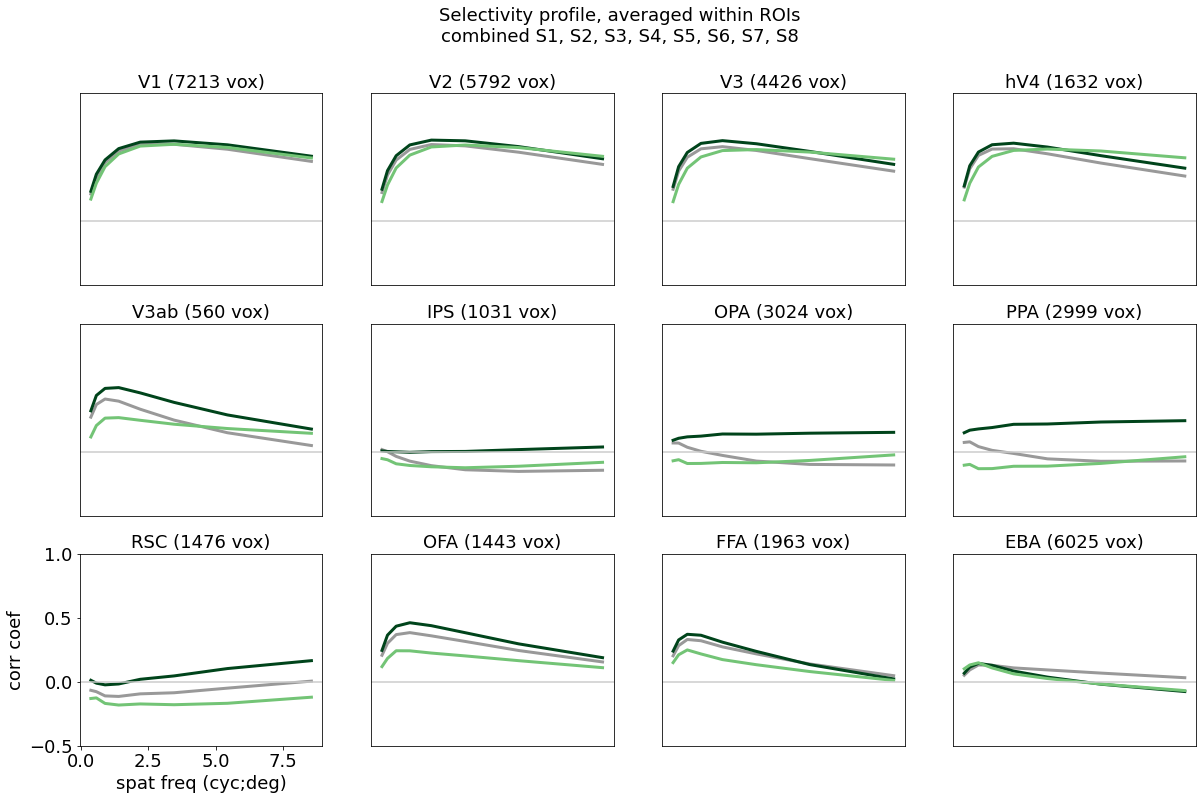

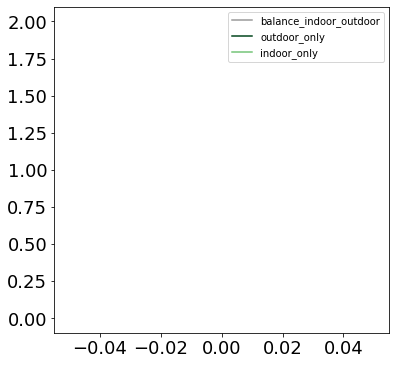

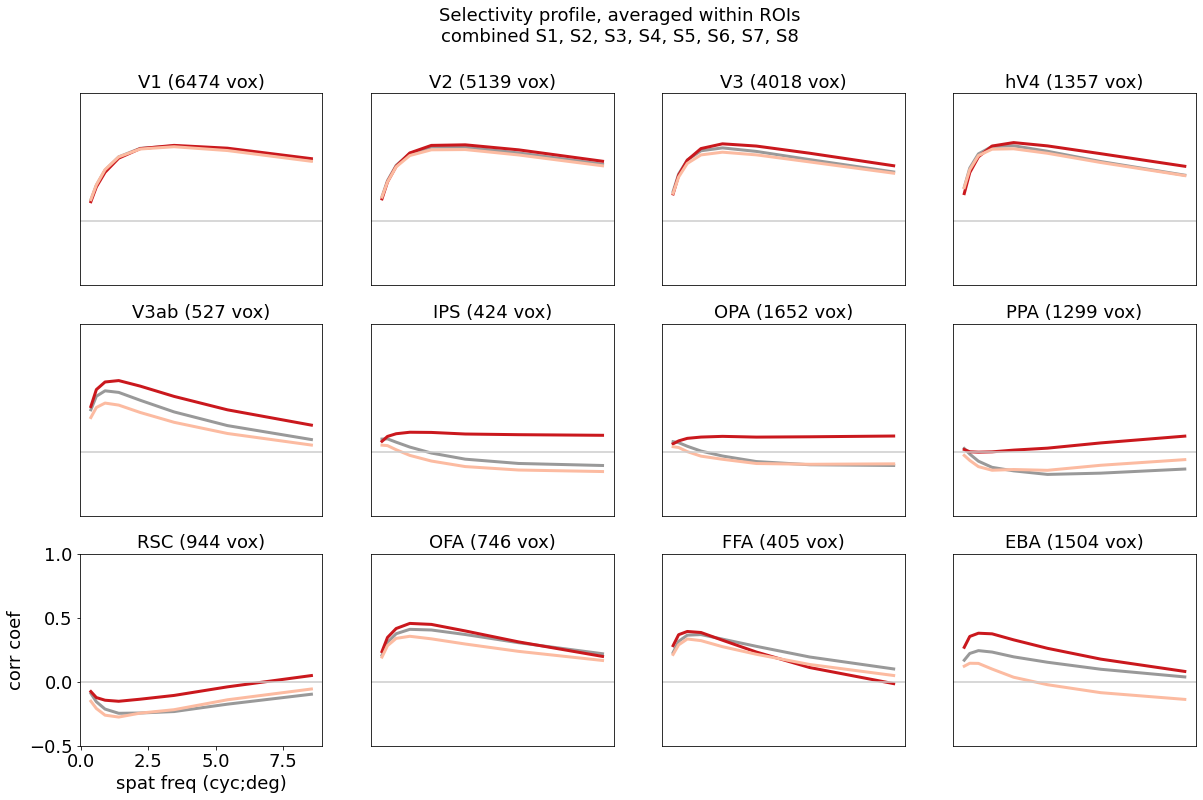

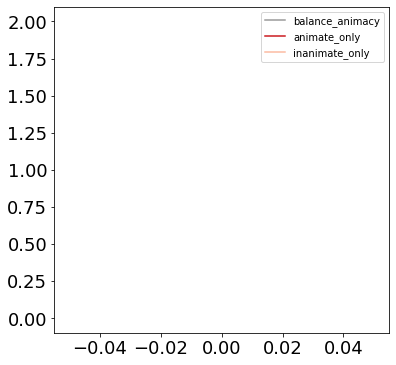

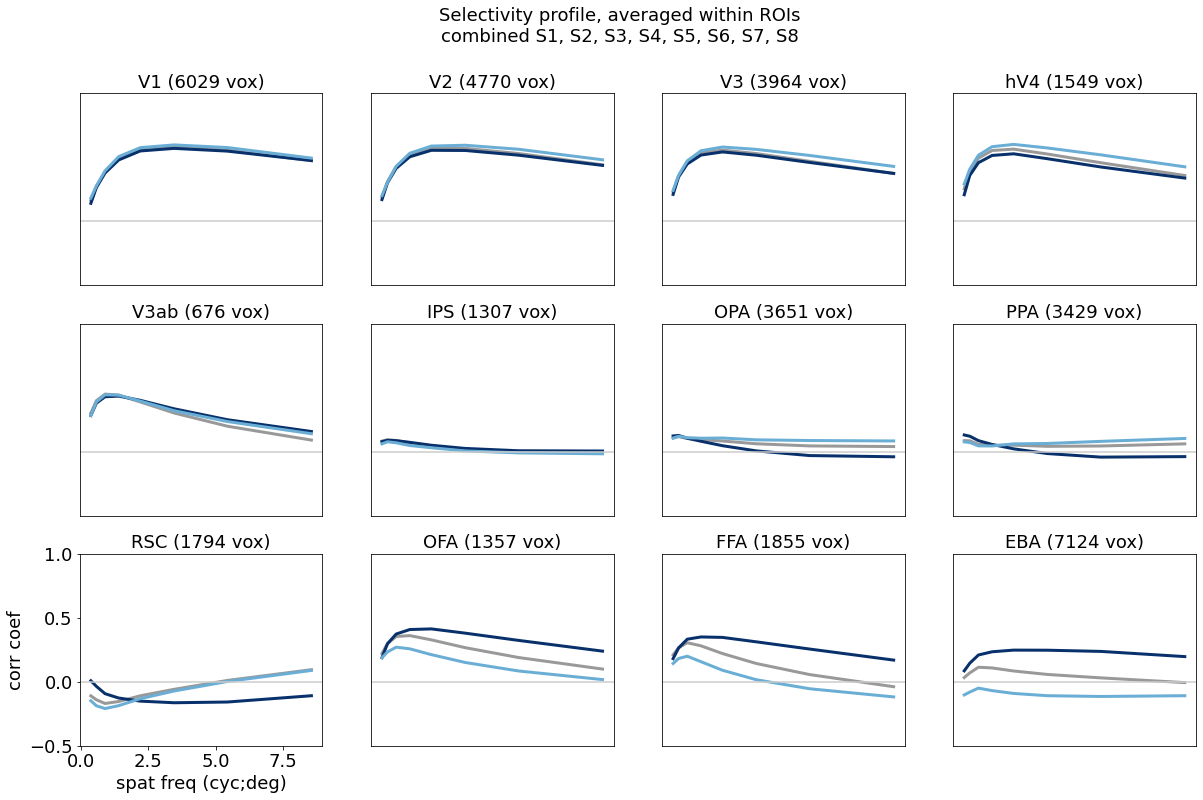

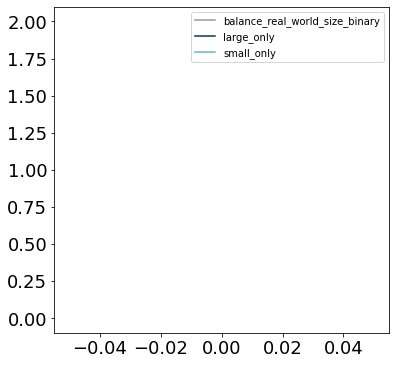

In [210]:
plot_utils.set_all_font_sizes(18)
subsets2group = [[0,1,2], [3,4,5], [6,7,8]];
n_groups = 3;

for gi, group in enumerate(subsets2group):

    plt.figure(figsize=(20,12))
    npy = int(np.ceil(np.sqrt(n_rois)))
    npx = int(np.ceil((n_rois)/npy))
    
    colors = colors_categ[gi]

    for rr in range(n_rois):

        for ti, ts in enumerate(group):
 
            inds_this_roi = roi_def.get_indices(rr) & \
                            np.concatenate([voxels_use[gi][si] for si in range(n_subjects)], axis=0)
           
            pi = rr+1;
            plt.subplot(npx,npy,pi)

            plt.plot(sf_unique,  np.mean(mean_sf_corr[inds_this_roi,:,ts], axis=0),\
                 '-',color=colors[ti,:],linewidth=3)

        plt.axhline(0, color=[0.8, 0.8, 0.8])
        plt.ylim([-0.5,1])

        if pi==(npx-1)*npy+1:
            plt.xlabel('spat freq (cyc;deg)')
            plt.ylabel('corr coef')
           
        else:
            plt.xticks([]);
            plt.yticks([])

        plt.title('%s (%d vox)'%(roi_names[rr], np.sum(inds_this_roi)))

    plt.suptitle('Selectivity profile, averaged within ROIs\n%s'%summary_plots.get_substr(out[0]))

    # plot_utils.set_all_font_sizes(10)
    plt.figure(figsize=(6,6));
    for ti, ts in enumerate(group):
        plt.plot(0,ti,color=colors[ti,:])    
    plt.legend(['%s'%trial_subsets[ts] for ts in group], prop={'size':10})
    # plot_utils.set_all_font_sizes(16)

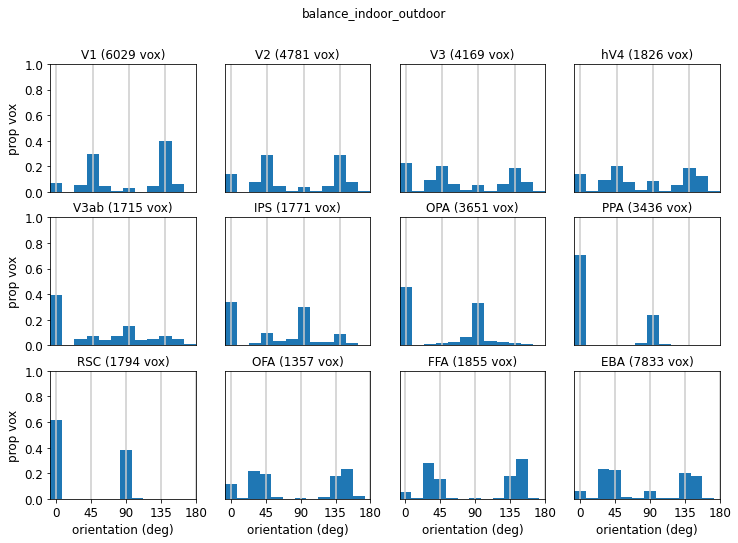

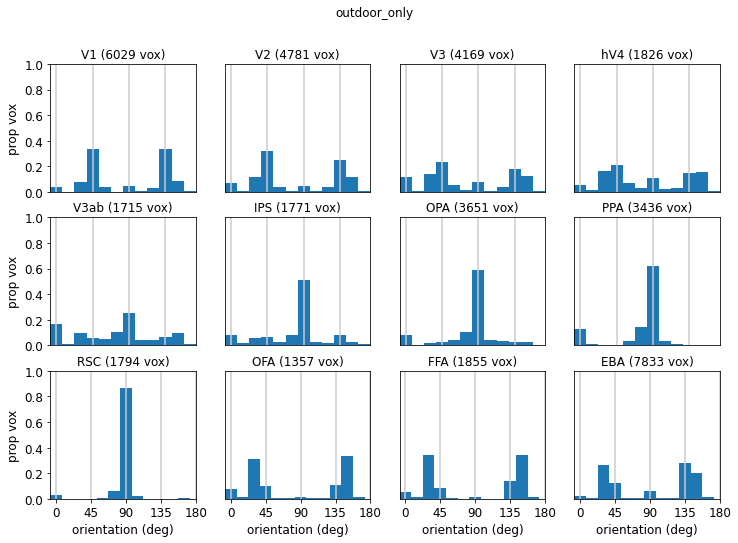

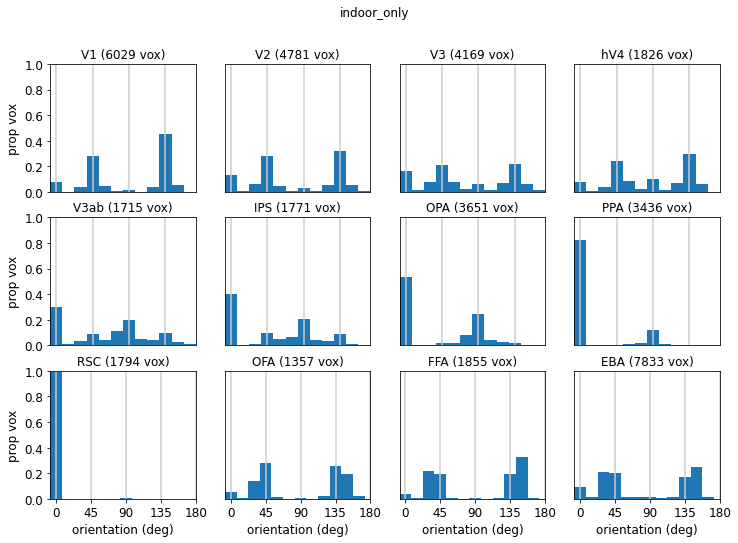

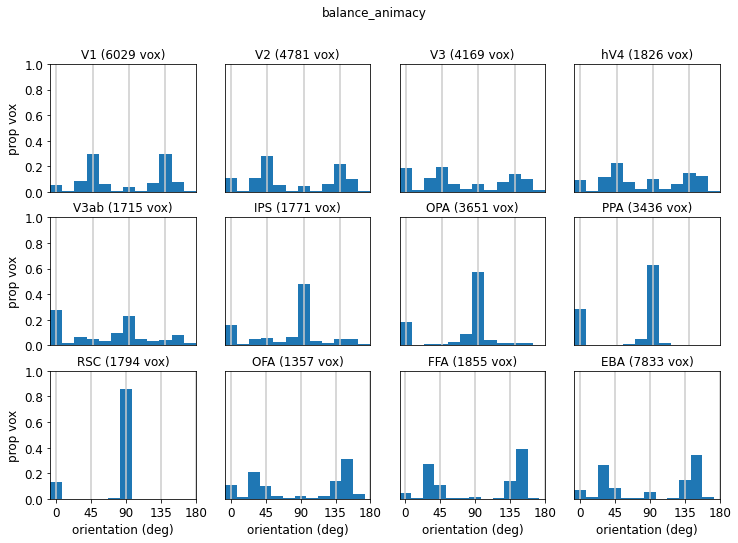

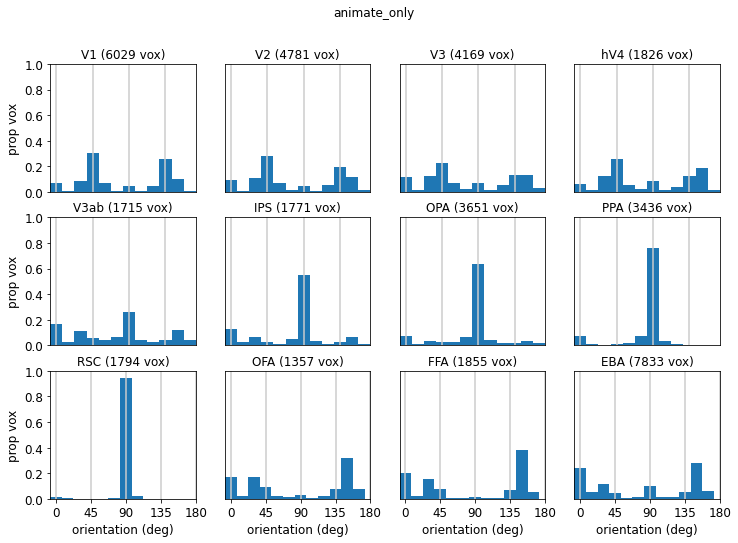

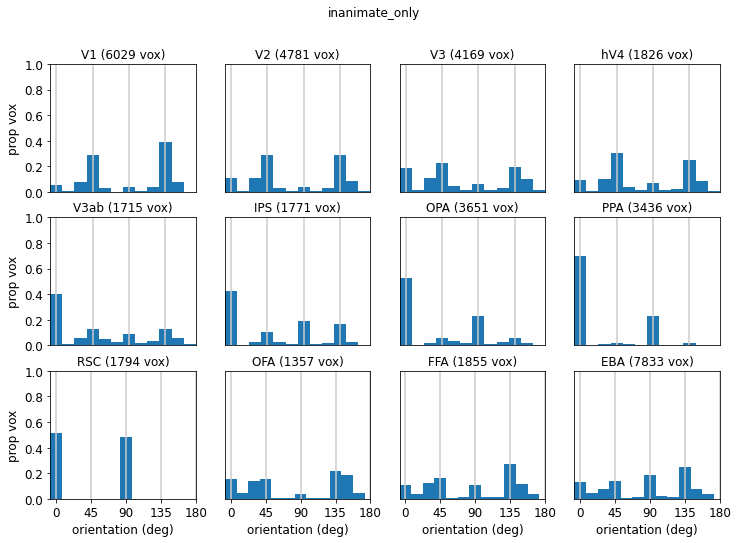

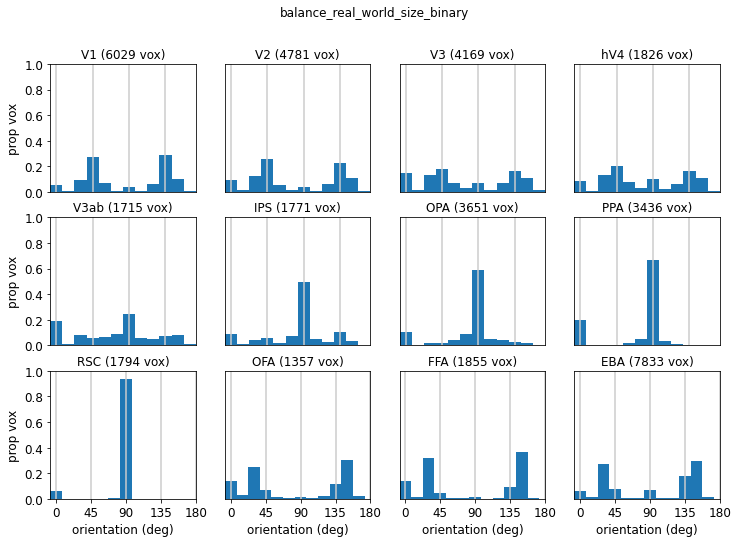

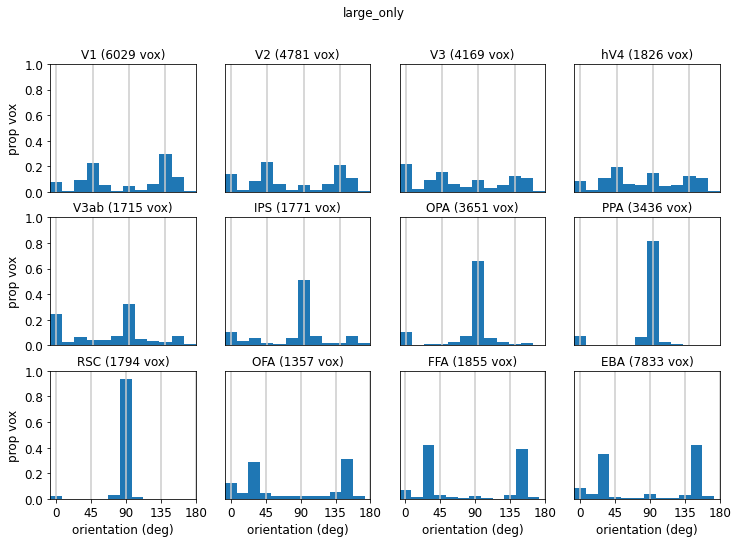

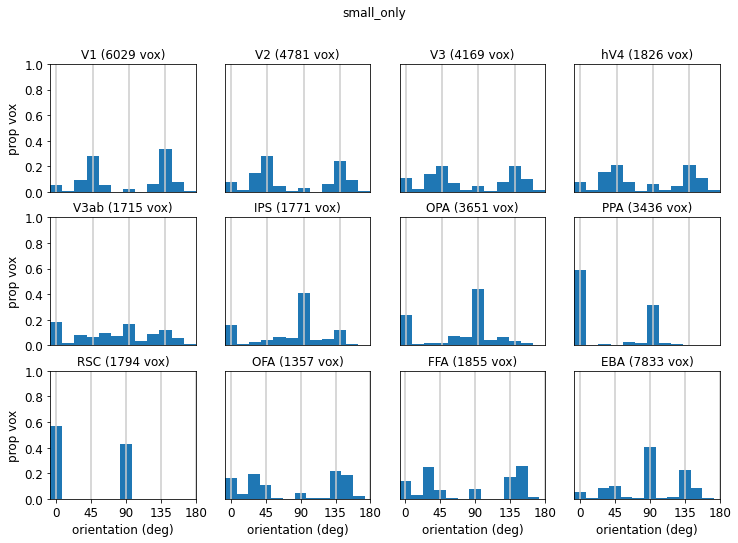

In [17]:
# Plot histograms of "preferred orientation"
# based on correlation coefficient method

plot_utils.set_all_font_sizes(12)

plt.rcParams['pdf.fonttype']=42

for ti in range(n_trial_subsets):

    # plot_utils.set_all_font_sizes(12)
    plt.figure(figsize=(12,8))
    npy = int(np.ceil(np.sqrt(n_rois)))
    npx = int(np.ceil((n_rois)/npy))

    pi=0
    for ri in range(n_rois):

        inds_this_roi = roi_def.get_indices(ri) & np.concatenate([voxels_use[gi][si] \
                                                                  for si in range(n_subjects)], axis=0)

        pi+=1
        plt.subplot(npx,npy,pi)

        spacing = ori_unique[1] - ori_unique[0]
        neach = [np.sum(preferred_ori_corr[inds_this_roi,ti]==oo) for oo in range(n_ori)]
        assert(np.sum(neach)==np.sum(inds_this_roi))
        propeach = neach/np.sum(inds_this_roi)
        plt.bar(ori_unique, propeach, width=spacing)

        plt.xlim([-spacing/2,180-spacing/2])
        plt.ylim([0, 1.0])
        if np.mod(pi, npy)==1:
            plt.ylabel('prop vox')
        else:
            plt.yticks([])

        if pi>=(npx-1)*npy+1:
            plt.xticks(np.arange(0,181,45))
            plt.xlabel('orientation (deg)')
        else:
            plt.xticks([]);

        for ii in np.arange(0,181,45):
            plt.axvline(ii,color=[0.8, 0.8, 0.8])

        plt.title('%s (%d vox)'%(roi_names[ri], np.sum(inds_this_roi)))

    plt.suptitle('%s'%trial_subsets[ti])

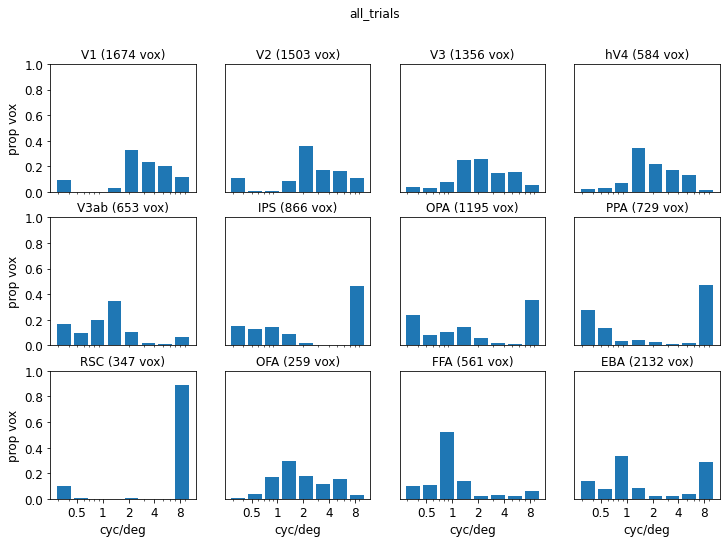

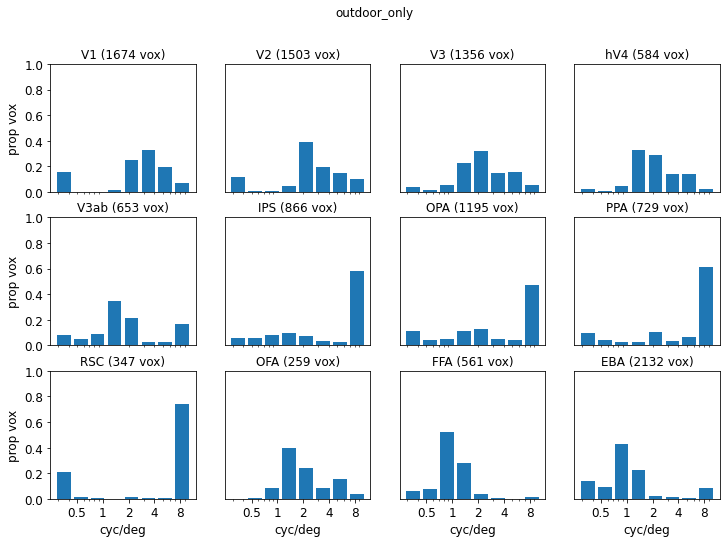

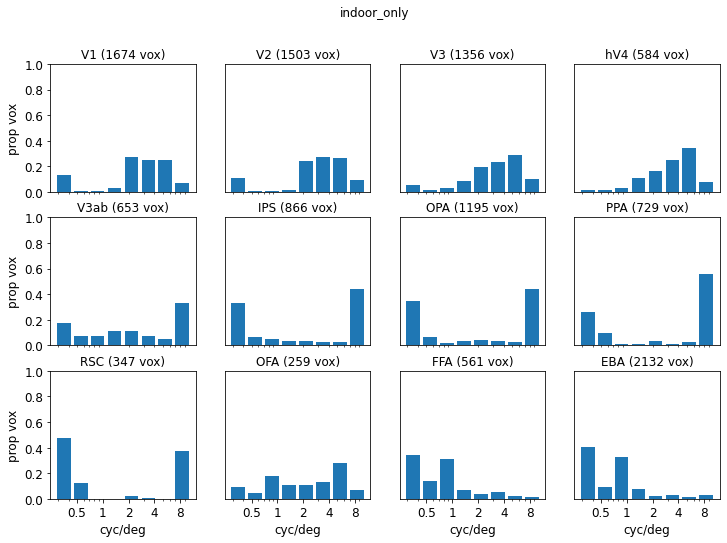

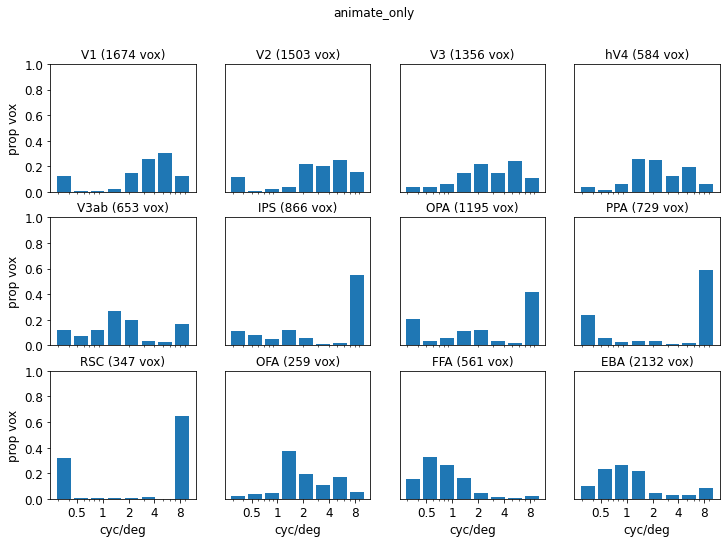

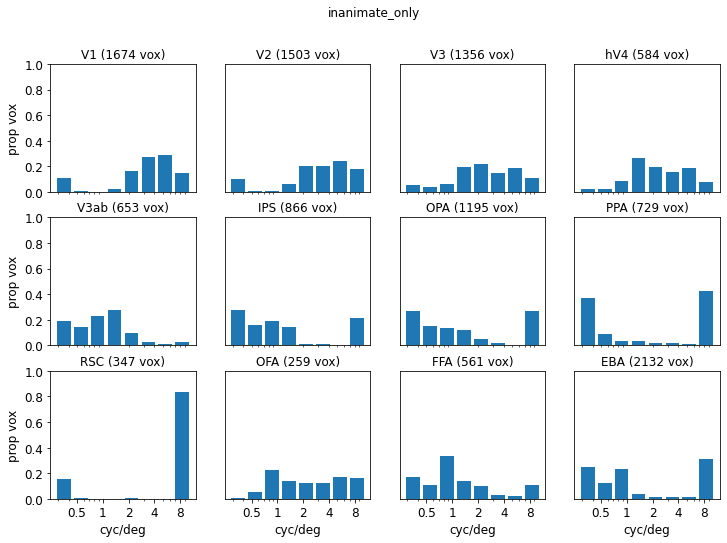

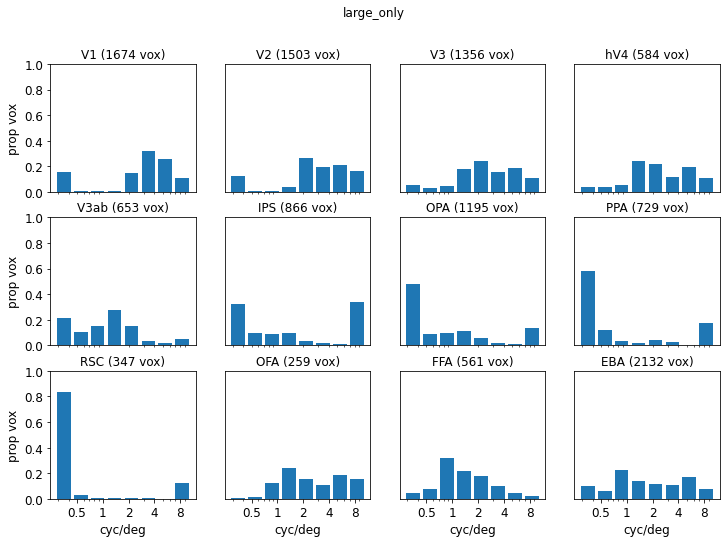

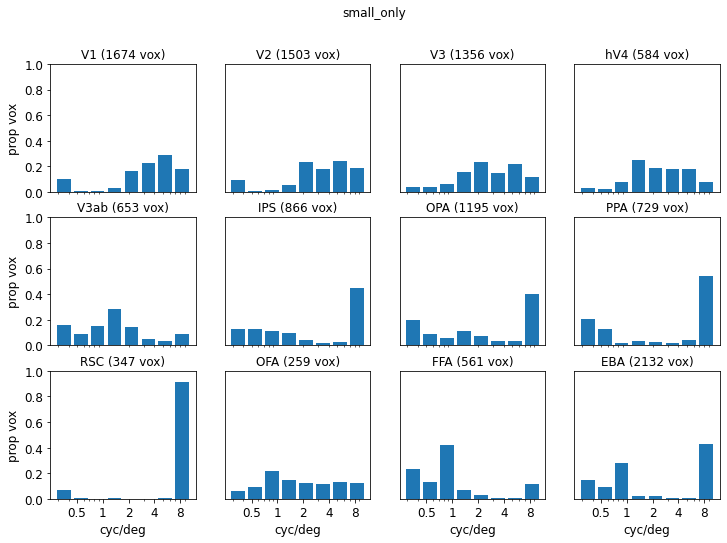

In [16]:
# Plot histograms of "preferred frequency"
# based on correlation coefficient method
plot_utils.set_all_font_sizes(12)

plt.rcParams['pdf.fonttype']=42

for ti in range(n_trial_subsets):

    plt.figure(figsize=(12,8))
    npy = int(np.ceil(np.sqrt(n_rois)))
    npx = int(np.ceil((n_rois)/npy))

    pi=0
    for ri in range(n_rois):

        inds_this_roi = roi_def.get_indices(ri) & np.concatenate(voxels_use, axis=0)

        pi+=1
        plt.subplot(npx,npy,pi)

        spacing = np.diff(sf_unique)
        if len(spacing)>1:
            dlog = np.log(spacing[1]) - np.log(spacing[0])                
        else:
            dlog = np.log(sf_unique[1]) - np.log(sf_unique[0])
            plt.xlim([10**np.log10(0.1), 10**np.log10(14)])
        spacing = np.concatenate([[np.exp(np.log(spacing[0]) - dlog)], spacing])

        neach = [np.sum(preferred_sf_corr[inds_this_roi,ti]==ff) for ff in range(n_sf)]
        assert(np.sum(neach)==np.sum(inds_this_roi))
        propeach = neach/np.sum(inds_this_roi)
        plt.bar(sf_unique, propeach, width=spacing)


        plt.gca().set_xscale('log')
        plt.ylim([0, 1.0])

        if np.mod(pi, npy)==1:
            plt.ylabel('prop vox')
        else:
            plt.yticks([])

        if pi>=(npx-1)*npy+1:
            plt.xlabel('cyc/deg')
            plt.xticks([10**np.log10(0.5), 10**np.log10(1), \
                        10**np.log10(2),10**np.log10(4), \
                        10**np.log10(8)],\
                       [0.5,1,2,4,8])
        else:
            plt.xticks([]);


        plt.title('%s (%d vox)'%(roi_names[ri], np.sum(inds_this_roi)))

    plt.suptitle('%s'%trial_subsets[ti])